In [4]:
from regions import DS9Parser, read_ds9
from regions import PixCoord, CirclePixelRegion,RectanglePixelRegion, PolygonPixelRegion,EllipsePixelRegion, PolygonSkyRegion
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import regions
from astropy.table import *
from tqdm import tqdm
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS

In [5]:
import matplotlib

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

100%|██████████| 2/2 [00:00<00:00, 117.76it/s]


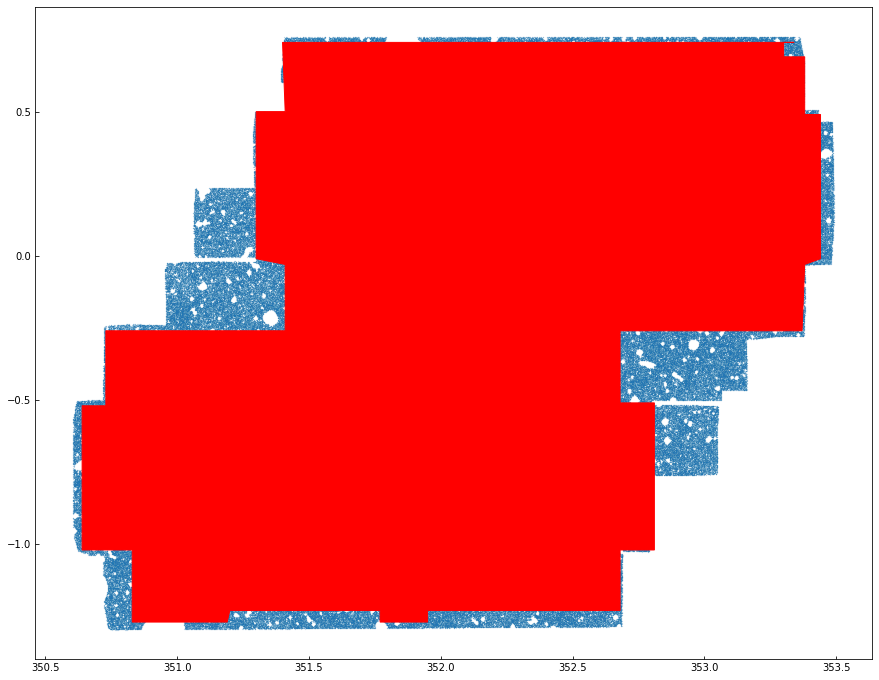

In [114]:
fig, ax = plt.subplots(figsize=(15, 12))

cat = Table.read('CUT_deep_catalogs/deep2_photoz_v2.fits')
cat = cat[cat['flag']==1]
cat = cat[cat['FLAG_FIELD_BINARY'][:,1]==True]

ax.scatter(cat['RA'],cat['DEC'],s=0.01)
file = open('uregion_test.txt')
lines = file.readlines()
for i in tqdm(range(len(lines))):
    line = lines[i]

    if ('circle' in line) or ('box' in line):
        line = 'wcs; fk5\n '+line
        region = DS9Parser(line).shapes.to_regions()[0]
        if isinstance(region, regions.shapes.circle.CircleSkyRegion):
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            pixel_ra_axis = region.radius.value/np.cos(region.center.dec.value/180*np.pi)
            pixel_dec_axis = region.radius.value
            pixel_region = EllipsePixelRegion(pixel_center, pixel_ra_axis*2,pixel_dec_axis*2)
                
        elif isinstance(region, regions.shapes.rectangle.RectangleSkyRegion):
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            width = region.width.value
            height = region.height.value
            angle = region.angle
            pixel_region = RectanglePixelRegion(pixel_center, width, height, angle)
        else:
            continue
                
    elif 'polygon' in line:
        line = 'wcs; fk5\n '+line
        try:
            region = DS9Parser(line).shapes.to_regions()[0]
        except ValueError:
            continue
            
        vertices = region.vertices
        pixel_vertex_x = []
        pixel_vertex_y = []
        for vertex in vertices:
            pixel_vertex_x.append(vertex.ra.value)
            pixel_vertex_y.append(vertex.dec.value)
            pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
    
    else:
        continue
                
    artist = pixel_region.as_artist(edgecolor='r',facecolor='r',fill=True)        
    ax.add_artist(artist)

### apply mask to random point catalog

In [9]:
cat_name = 'DEEP_deep'
cat_random_name = 'CUT_deep_catalogs/'+cat_name+'_random_point_v2.fits'
cat_random = Table.read(cat_random_name)

# load region file
file = open('CUT_deep_catalogs/region_files/'+cat_name+'_mask.reg')
lines = file.readlines()

# make new column for mask flag
mask_new_column = Column(data=np.zeros(len(cat_random)),name='MASK_NEW')
cat_random.add_column(mask_new_column)
for i in tqdm(range(len(lines))):
    line = lines[i]
    line = 'wcs; fk5\n '+line
    if ('circle' in line) or ('box' in line):
        region = DS9Parser(line).shapes.to_regions()[0]
        if 'circle' in line:
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            pixel_radius = region.radius.value
            pixel_region = CirclePixelRegion(pixel_center, pixel_radius)
            
        elif 'box' in line:
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            width = region.width.value
            height = region.height.value
            angle = region.angle
            pixel_region = RectanglePixelRegion(pixel_center, width, height, angle)
                
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        cat_random['MASK_NEW'] += pixel_region.contains(pixel_coord)
                
    elif 'polygon' in line:
        try:
            region = DS9Parser(line).shapes.to_regions()[0]
        except ValueError:
            continue

        vertices = region.vertices
        pixel_vertex_x = []
        pixel_vertex_y = []
        for vertex in vertices:
            pixel_vertex_x.append(vertex.ra.value)
            pixel_vertex_y.append(vertex.dec.value)
            pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        cat_random['MASK_NEW'] += pixel_region.contains(pixel_coord)
        
    else:
        continue

cat_random.write(cat_random_name,overwrite=True)

# make inside flag:
inside_column = Column(data=np.zeros(len(cat_random)),name='inside')
try:
    cat_random.add_column(inside_column)
except ValueError:
    cat_random.remove_column('inside')
    cat_random.add_column(inside_column)
    
clean_region = read_ds9('CUT_deep_catalogs/region_files/'+cat_name+'_uregion.reg')[0]
if 'polygon' in line:
    vertices = clean_region.vertices
    pixel_vertex_x = []
    pixel_vertex_y = []
    for vertex in vertices:
        pixel_vertex_x.append(vertex.ra.value)
        pixel_vertex_y.append(vertex.dec.value)
        pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
    pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
    cat_random['inside'] = pixel_region.contains(pixel_coord)

cat_random.write(cat_random_name,overwrite=True)

### cut region file into 4 (one per field)

In [10]:
file = open('CUT_deep_catalogs/VeniceAndMine2.reg')
lines = file.readlines()
save_path = 'CUT_deep_catalogs/region_files/'

reg_file_COSMOS = open(save_path+'COSMOS_deep_mask.reg','w')
reg_file_ELAIS = open(save_path+'ELAIS_deep_mask.reg','w')
reg_file_DEEP = open(save_path+'DEEP_deep_mask.reg','w')
reg_file_XMM = open(save_path+'XMM-LSS_deep_mask.reg','w')

reg_file_COSMOS.write('wcs; fk5\n ')
reg_file_ELAIS.write('wcs; fk5\n ')
reg_file_DEEP.write('wcs; fk5\n ')
reg_file_XMM.write('wcs; fk5\n ')

for i in tqdm(range(len(lines))):
    line = lines[i]
    line_append = 'wcs; fk5\n '+line
    
    if ('circle' in line) or ('box' in line):
        region = DS9Parser(line_append).shapes.to_regions()[0]
        x = region.center.ra.value    
    elif 'polygon' in line:
        try:
            region = DS9Parser(line_append).shapes.to_regions()[0]
            x = region.vertices[0].ra.value
        except ValueError:
            continue
    else:
        continue

    if x>34.8 and x<37.7:
        reg_file_XMM.write(line)
    elif x>148.4 and x<151.8:
        reg_file_COSMOS.write(line)
    elif x>240.6 and x<245.0:
        reg_file_ELAIS.write(line)
    elif x>350.6 and x<353.5:
        reg_file_DEEP.write(line)

reg_file_COSMOS.close()
reg_file_ELAIS.close()
reg_file_DEEP.close()
reg_file_XMM.close()



  7%|▋         | 34867/508102 [00:27<06:15, 1258.67it/s]


 14%|█▍        | 70144/508102 [00:55<05:45, 1267.37it/s]


 21%|██        | 105146/508102 [01:22<05:18, 1267.00it/s]


 28%|██▊       | 139801/508102 [01:50<04:50, 1268.63it/s]


 34%|███▍      | 174460/508102 [02:17<04:22, 1269.75it/s]


 41%|████      | 209027/508102 [02:44<03:55, 1269.72it/s]


 48%|████▊     | 243683/508102 [03:11<03:28, 1270.21it/s]


 55%|█████▍    | 278245/508102 [03:39<03:00, 1270.08it/s]


 61%|██████▏   | 312439/508102 [04:06<02:34, 1268.53it/s]


 68%|██████▊   | 347019/508102 [04:33<02:06, 1268.54it/s]


 75%|███████▌  | 381443/508102 [05:00<01:39, 1268.09it/s]


 82%|████████▏ | 416230/508102 [05:28<01:12, 1268.88it/s]


 89%|████████▊ | 450806/508102 [05:55<00:45, 1268.58it/s]


 96%|█████████▌| 485546/508102 [06:22<00:17, 1269.01it/s]


100%|██████████| 508102/508102 [06:44<00:00, 1257.02it/s]

NameError: name 'reg_file_SXDS' is not defined

### match the central galaxies

In [34]:
import subprocess,os
save_path = 'CUT_deep_catalogs/v2_matched_centrals/'
central_path = 'CUT_deep_catalogs/total_sample_old_cat_0718/'
for cat_name in ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']:
    for z in [0.4, 0.6, 0.8]:
        additional_path = cat_name+'_'+str(z*10)+'/'
        cat = Table.read(central_path+additional_path+'isolated_'+cat_name+'_11.15_'+str(z)+'_massive_normal_params_old.positions.fits')
        print(cat_name,z,len(cat))
        cmd ='java -jar ~/stilts.jar tmatch2 in1='+central_path+additional_path+'isolated_'+cat_name+'_11.15_'+str(z)+'_massive_normal_params_old.positions.fits\
                                                      in2=CUT_deep_catalogs/'+cat_name+'_photoz_v2_cut.fits join=1and2 \
                                                      matcher=sky params=0.5 values1="RA DEC" values2="RA DEC" \
                                                      out='+save_path+'central_'+cat_name+'_'+str(z)+'.fits'
        os.system(cmd)
#         file = open('kk.txt')
#         print(file.read())
        
for cat_name in ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']:
    for z in [0.4, 0.6,  0.8]: 
        cat = Table.read(save_path+'/central_'+cat_name+'_'+str(z)+'.fits')
        print(cat_name,z,len(cat))
        cat.rename_column('RA_1','RA')
        cat.rename_column('DEC_1','DEC')
        cat.write(save_path+'/central_'+cat_name+'_'+str(z)+'.fits',overwrite=True)

ELAIS_deep 0.4 174
ELAIS_deep 0.6 208
ELAIS_deep 0.8 327
DEEP_deep 0.4 159
DEEP_deep 0.6 217
DEEP_deep 0.8 305
COSMOS_deep 0.4 162
COSMOS_deep 0.6 171
COSMOS_deep 0.8 314
XMM-LSS_deep 0.4 173
XMM-LSS_deep 0.6 166
XMM-LSS_deep 0.8 324
ELAIS_deep 0.4 173
ELAIS_deep 0.6 207
ELAIS_deep 0.8 325
DEEP_deep 0.4 158
DEEP_deep 0.6 215
DEEP_deep 0.8 295
COSMOS_deep 0.4 162
COSMOS_deep 0.6 169
COSMOS_deep 0.8 305
XMM-LSS_deep 0.4 172
XMM-LSS_deep 0.6 166
XMM-LSS_deep 0.8 320


In [78]:
for cat_name in ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']:
    print(cat_name)
    cat = Table.read('CUT_deep_catalogs/'+cat_name+'_photoz_v2_cut.fits')
    column = Column(data=np.ones(len(cat)), name='sfProb',dtype='i4')
    try:
        cat.add_column(column)
    except ValueError as e:
        print(e)
        continue
    cat.write('CUT_deep_catalogs/'+cat_name+'_photoz_v2_cut.fits',overwrite=True)

Duplicate column names
Duplicate column names


In [82]:
for cat_name in ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']:
    print(cat_name)
    cat = Table.read('CUT_deep_catalogs/v2_matched_centrals/'+'central_'+cat_name+'_'+str(z)+'.fits')
    print(len(cat.keys()))

ELAIS_deep
104
DEEP_deep
104
COSMOS_deep
106
XMM-LSS_deep
104


### make new random point catalogs

In [2]:
import random

In [7]:
cat_name = 'XMM-LSS_deep'

ra_min, ra_max = (33.5, 37.8)
dec_min, dec_max = (-6.2, -3.2)
density = 5e4   # number per square arcsec
dec_bins =np.linspace(dec_min,dec_max,100)

cat_random_point = Table(names=('RA','DEC'),dtype=('f8','f8'))
for i in tqdm(range(len(dec_bins[:-1]))):
    area = (ra_max - ra_min)*(dec_bins[i+1]-dec_bins[i])*np.cos(dec_bins[i]/180*np.pi)
    rand_p_num = int(density*area) 
    for k in range(rand_p_num):
        ra_rand = random.uniform(ra_min, ra_max)
        dec_rand = random.uniform(dec_bins[i], dec_bins[i+1])
        cat_random_point.add_row([ra_rand,dec_rand])
    
cat_random_point.write('CUT_deep_catalogs/'+cat_name+'_random_point_v2.fits',overwrite=True)


100%|██████████| 99/99 [54:35<00:00, 33.08s/it]


In [40]:
for cat_name in ['COSMOS_deep','DEEP_deep','XMM-LSS_deep','ELAIS_deep']:
    if cat_name == "COSMOS_deep":
        ra_min=148.3
        ra_max=151.9
        dec_min=0.6
        dec_max=4.0
    elif cat_name == "XMM-LSS_deep":
        ra_min=33.5
        ra_max=37.8
        dec_min=-6.2
        dec_max=-3.2
    elif cat_name == "DEEP_deep":
        ra_min=350.2
        ra_max=354.1
        dec_min=-1.7
        dec_max=1.1
    elif cat_name == "ELAIS_deep":
        ra_min=239.8
        ra_max=245.8
        dec_min=53.2
        dec_max=57.0
    else:
        print('wrong cat name')
        
    density = 5e4 * 4   # number per square arcsec\
    n = 0
    dec_bins =np.linspace(dec_min,dec_max,100)
    for i in tqdm(range(len(dec_bins[:-1]))):
        area = (ra_max - ra_min)*(dec_bins[i+1]-dec_bins[i])*np.cos(dec_bins[i]/180*np.pi)
        n += area*density
    print(cat_name, n)

100%|██████████| 99/99 [00:00<00:00, 139387.75it/s]

COSMOS_deep 2445698.369968648
DEEP_deep 2183749.879015167
XMM-LSS_deep 2570974.7843951667
ELAIS_deep 2609759.4346506502


In [68]:
cat_name = 'DEEP_deep'
cat_random_name = 'CUT_deep_catalogs/'+cat_name+'_random_point.fits'
cat_random = Table.read(cat_random_name)

# make inside flag:
inside_column = Column(data=np.zeros(len(cat_random)), name='inside')
try:
    cat_random.add_column(inside_column)
except ValueError:
    cat_random.remove_column('inside')
    cat_random.add_column(inside_column)

clean_regions = read_ds9('CUT_deep_catalogs/'+'region_files/' + cat_name + '_uregion.reg')
for clean_region in clean_regions:
    if isinstance(clean_region, regions.shapes.polygon.PolygonSkyRegion):
        print('a polygon region', clean_region)
        vertices = clean_region.vertices
        pixel_vertex_x = []
        pixel_vertex_y = []
        for vertex in vertices:
            pixel_vertex_x.append(vertex.ra.value)
            pixel_vertex_y.append(vertex.dec.value)

        pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        cat_random['inside'] += pixel_region.contains(pixel_coord)
        
cat_random.write(cat_random_name, overwrite=True)

1
a polygon region Region: PolygonSkyRegion
vertices: <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(350.7479297, -1.2963812), (350.8925679, -1.2972227),
     (351.0165434, -1.2966968), (351.1611816, -1.2972227),
     (351.2644946, -1.2956045), (351.3884702, -1.2933835),
     (351.5331084, -1.2904488), (351.6777466, -1.2900701),
     (351.7810596, -1.2895968), (351.9256977, -1.2893128),
     (352.0496733, -1.2920897), (352.1943115, -1.2928241),
     (352.3389497, -1.2919024), (352.4835879, -1.2904144),
     (352.6282261, -1.2862835), (352.6775193, -1.2821444),
     (352.6874791, -1.1272449), (352.6902139, -1.0247831),
     (352.7784231, -1.0223167), (352.7891089, -0.5029769),
     (352.676189 , -0.5087824), (352.6811402, -0.2892133),
     (353.1559156, -0.2841073), (353.2894292, -0.2783179),
     (353.3673094, -0.2791347), (353.3824109, -0.1654402),
     (353.3824109, -0.0830809), (353.4101564, -0.0849052),
     (353.41267  , -0.0168013), (353.483274 , -0.0168008),
     (35

In [69]:
cat_name = 'DEEP_deep'
cat_random_name = 'CUT_deep_catalogs/'+cat_name+'_random_point.fits'
cat_random = Table.read(cat_random_name)

clean_region = read_ds9('CUT_deep_catalogs/region_files/'+cat_name+'_uregion.reg')[0]
if 'polygon' in line:
    vertices = clean_region.vertices
    pixel_vertex_x = []
    pixel_vertex_y = []
    for vertex in vertices:
        pixel_vertex_x.append(vertex.ra.value)
        pixel_vertex_y.append(vertex.dec.value)
        pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
    pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
    cat_random['inside'] = pixel_region.contains(pixel_coord)

cat_random.write(cat_random_name,overwrite=True)

In [84]:
cat_name = 'DEEP_deep'
cat_random_name = 'CUT_deep_catalogs/'+cat_name+'_random_point.fits'
cat_random = Table.read(cat_random_name)
mask_flag_list = np.zeros(len(cat_random))

# load region file
file = open('CUT_deep_catalogs/region_files/'+cat_name+'_mask.reg')
lines = file.readlines()[-1000:]
for i in range(len(lines)):
    line = lines[i]
    print(line)
    line = 'wcs; fk5\n '+line
    if ('circle' in line) or ('box' in line):
        region = DS9Parser(line).shapes.to_regions()[0]
        if 'circle' in line:
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            pixel_radius = region.radius.value
            pixel_region = CirclePixelRegion(pixel_center, pixel_radius)
            
        elif 'box' in line:
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            width = region.width.value
            height = region.height.value
            angle = region.angle
            pixel_region = RectanglePixelRegion(pixel_center, width, height, angle)
                
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        mask_flag_list += pixel_region.contains(pixel_coord)
                
    elif 'polygon' in line:
        try:
            region = DS9Parser(line).shapes.to_regions()[0]
        except ValueError:
            continue

        vertices = region.vertices
        pixel_vertex_x = []
        pixel_vertex_y = []
        for vertex in vertices:
            pixel_vertex_x.append(vertex.ra.value)
            pixel_vertex_y.append(vertex.dec.value)
            pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        mask_flag_list += pixel_region.contains(pixel_coord)
        
    else:
        continue

print(len(cat_random))
print(len(mask_flag_list))
print(len(mask_flag_list[mask_flag_list==0]))
np.save('CUT_deep_catalogs/mask_flag.npy',mask_flag_list)

polygon(351.8717476,-0.1000160554,351.8734121,-0.09377441851,351.8688351,-0.08919716244,351.8642579,-0.09377432547,351.8659222,-0.1000159922,351.8688348,-0.1029287954)

polygon(351.6033704,-0.1000120744,351.6055896,-0.09377070705,351.6004583,-0.08863879711,351.5942172,-0.09085785345,351.5879761,-0.09252211375,351.5854796,-0.09377034567,351.5817349,-0.09751510532,351.5804866,-0.1000116334,351.5817348,-0.1012599343,351.5879757,-0.1037566135,351.5917204,-0.1000118519,351.594217,-0.09668315522,351.5975454,-0.1000119637,351.6004578,-0.1029246747)

polygon(352.96235,-0.09376840722,352.9611017,-0.09127193416,352.9606855,-0.08752719398,352.9548606,-0.08228465418,352.9496186,-0.08752740948,352.9494524,-0.09376867664,352.9548613,-0.09917765488,352.9611019,-0.09501668331)

polygon(352.690239,-0.09377308392,352.6877423,-0.08753155598,352.686494,-0.08628325921,352.6839975,-0.08753160202,352.6802527,-0.091276588,352.6790045,-0.09377323155,352.6802528,-0.09502152911,352.6864943,-0.09751807187)

polyg

polygon(351.2807623,-0.06255884852,351.2813569,-0.0563179447,351.2796932,-0.05007700918,351.2759493,-0.04633241539,351.2697093,-0.04550021303,351.2651331,-0.05007679706,351.2634689,-0.05340524114,351.2605567,-0.05631760363,351.2634686,-0.05923006317,351.2643004,-0.06255854933,351.2697081,-0.06796742496,351.2759482,-0.06737317584)

polygon(350.9997453,-0.06255303266,350.9951704,-0.05797668681,350.9889314,-0.0596406335,350.9860197,-0.06255271005,350.988931,-0.0654649247,350.9951698,-0.06712916579)

polygon(350.9435961,-0.06255169024,350.944262,-0.05631150253,350.9390219,-0.05048721125,350.9377742,-0.05007117427,350.9327836,-0.04632697365,350.9290402,-0.05007100186,350.9265446,-0.05131898366,350.9215534,-0.05631099846,350.9228007,-0.06255117781,350.9265435,-0.06629536844,350.932782,-0.06795957965,350.9390207,-0.06712772028)

polygon(353.2444091,-0.05631672656,353.2431608,-0.05007598891,353.2419128,-0.04882785624,353.2356727,-0.04494480389,353.2305425,-0.05007618323,353.2310975,-0.05631695

polygon(352.6440508,-0.01887467618,352.645715,-0.01263311297,352.6428023,-0.009720390069,352.6365608,-0.007223772499,352.6311517,-0.01263313504,352.6328162,-0.01887470211,352.6365612,-0.02261963541,352.6428026,-0.0201229919)

polygon(352.1651075,-0.01887513744,352.1684365,-0.01388175629,352.1696848,-0.01263341143,352.1696849,-0.006391687667,352.1684365,-0.005143343201,352.1621948,-0.0008157505601,352.155953,-0.003478882594,352.1530402,-0.006391684227,352.1530402,-0.01263340609,352.155953,-0.01554621222,352.1592819,-0.01887513493,352.1621947,-0.02178794352)

polygon(352.0361118,-0.01887503622,352.0311185,-0.01388167331,352.0248768,-0.0132991097,352.0193009,-0.01887501599,352.0248767,-0.02445093919,352.0311184,-0.02386838997)

polygon(351.6470608,-0.01887415155,351.6487253,-0.01263273867,351.6441486,-0.008055694134,351.6395716,-0.01263271751,351.6412357,-0.01887413169,351.6441482,-0.02178680263)

polygon(351.150045,-0.01887175539,351.1478269,-0.01263110698,351.1449153,-0.009718802721,351

polygon(353.1097596,0.01233189636,353.1046285,0.01746337608,353.0994979,0.01233193133,353.104629,0.007200448556)

polygon(353.0933963,0.01233195193,353.0971401,0.01857291893,353.0933957,0.0248139188,353.0921475,0.02606212316,353.0859071,0.02772643051,353.0829951,0.02481398788,353.0796671,0.02231760895,353.075923,0.01857302468,353.0796674,0.01482840172,353.0821637,0.0123319895,353.0859081,0.008587375858,353.0921483,0.01108375798)

polygon(352.9515283,0.01233239155,352.9486159,0.01524496313,352.9452873,0.01857361966,352.9423749,0.02148619696,352.9394626,0.01857364394,352.9372439,0.01233243162,352.9423754,0.007200748546,352.9486161,0.00941983541)

polygon(352.523381,0.01857488175,352.5179716,0.02398429582,352.5125623,0.01857490087,352.5179718,0.01316548335)

polygon(352.1634432,0.01857516232,352.1659399,0.02481686369,352.1621949,0.02856188025,352.1559531,0.02606519935,352.1547048,0.0248168595,352.1559531,0.02232018074,352.1596981,0.01857516138,352.1621948,0.01732682135)

polygon(351.82764

polygon(353.0901498,0.04353686928,353.0908983,0.04977782501,353.0859058,0.05477066521,353.0796655,0.05502039447,353.0744239,0.04977804162,353.0748521,0.04353704534,353.0796663,0.03872251407,353.0859066,0.03929305392)

polygon(352.2907747,0.04354191313,352.2882779,0.04978359436,352.2870296,0.05103193084,352.2845329,0.04978359838,352.2807879,0.04603859506,352.2795395,0.04354192363,352.2807879,0.04229358596,352.2870296,0.03979690687)

polygon(352.2150416,0.04354195148,352.2121288,0.04791113004,352.2083838,0.04978363403,352.2058871,0.0510319696,352.2046387,0.04978363352,352.200755,0.04354195018,352.2058871,0.03840989664,352.2121288,0.04062916422)

polygon(352.0175262,0.04354169356,352.015307,0.04978333029,352.0123943,0.05269608549,352.0094815,0.04978331234,352.0061525,0.04645442846,352.0032397,0.04354165484,352.0061525,0.04062889627,352.0123941,0.03840965963)

polygon(351.8552451,0.04354109444,351.8501134,0.04867301284,351.8449814,0.0435410448,351.8501132,0.03840912309)

polygon(351.414488

polygon(351.2688081,0.07474006149,351.2688085,0.08098085242,351.2634764,0.08631375349,351.2576105,0.08098058869,351.2572359,0.07723611866,351.2559878,0.07473978267,351.2572357,0.07349165526,351.2634755,0.06940690985)

polygon(350.9248902,0.07473128571,350.9248907,0.0809713413,350.9203161,0.08554722361,350.9157408,0.08097104842,350.9157404,0.07473101546,350.920315,0.07015511443)

polygon(353.3134528,0.08097715646,353.3105409,0.08388947851,353.3043012,0.08610850803,353.2991713,0.08097753995,353.3043019,0.07584629326,353.3105412,0.07806499024)

polygon(352.616725,0.08099000041,352.611593,0.08612195332,352.6064613,0.08099010011,352.6115932,0.07585814359)

polygon(352.5957815,0.0809902011,352.5928687,0.08390293656,352.5866272,0.08556740121,352.5820502,0.0809903268,352.5866274,0.07641316624,352.5928688,0.07807751837)

polygon(352.1526244,0.08099191046,352.1551211,0.08723355764,352.1526245,0.09347518985,352.1553292,0.09971682504,352.1526245,0.1059584429,352.1497117,0.1088711915,352.1467989,0.

polygon(352.5021582,0.1121987627,352.5043773,0.1184402788,352.4992453,0.123572259,352.4941134,0.1184403825,352.4963327,0.1121988185,352.4992455,0.1092860695)

polygon(351.8240394,0.1121974701,351.8243169,0.1184389376,351.8226527,0.1246803692,351.8189079,0.1284251805,351.8126666,0.1296733698,351.8076733,0.1246801394,351.806425,0.123253505,351.8016101,0.118438605,351.8026799,0.1121971741,351.8064247,0.1084523538,351.812666,0.1067880479,351.8189074,0.1070655283)

polygon(351.2243744,0.1121832332,351.2249294,0.1184239217,351.2197992,0.1235549411,351.2148074,0.1246642,351.2135596,0.1259122796,351.20732,0.1292403698,351.2027439,0.1246637371,351.2044075,0.1184231781,351.2073192,0.1155109886,351.2135589,0.1140550587,351.2143076,0.1121828893,351.2197983,0.1076065889)

polygon(350.8857988,0.112169767,350.8891261,0.1146658897,350.8928694,0.118410024,350.8891268,0.1234017805,350.8872554,0.1246496691,350.8828888,0.1275614002,350.8799774,0.1246493,350.8772736,0.1184092734,350.8799764,0.1121695012,35

polygon(352.84002,0.1433997176,352.8425163,0.146728296,352.8454287,0.1496407766,352.8425161,0.1540097016,352.8418919,0.1558820797,352.8362749,0.1606968865,352.830034,0.1571306691,352.8287858,0.1558824629,352.8262897,0.1496413143,352.8300344,0.1458964768,352.8325309,0.1433999194,352.8362756,0.1396550849)

polygon(352.6916197,0.1434032596,352.6864879,0.1485351592,352.6813563,0.143403469,352.6864881,0.1382715653)

polygon(352.6233256,0.1434045664,352.6240745,0.1452769807,352.6269871,0.1496459216,352.6240744,0.1525586365,352.6231664,0.1558874072,352.6226475,0.1621288245,352.6178326,0.1669437169,352.6165843,0.1683703479,352.6115911,0.1733635689,352.6053497,0.173363697,352.5991083,0.171283354,352.5961957,0.1683707523,352.5935804,0.1621293821,352.5934914,0.155887955,352.5936995,0.1496465146,352.5991089,0.1437454233,352.5997331,0.1434049705,352.6053504,0.1385900489,352.6115919,0.1388277156,352.6178333,0.1388276113)

polygon(352.4731691,0.1434067232,352.473169,0.1496482393,352.468037,0.15478020

polygon(352.097282,0.1808570515,352.093537,0.1846019335,352.0872954,0.1858501896,352.082302,0.1808569442,352.0872953,0.1758637676,352.093537,0.1771121151)

polygon(352.0465166,0.1808566377,352.0487359,0.1870981569,352.043604,0.1922299966,352.0373624,0.1925073302,352.0311207,0.1916750648,352.0265435,0.1870979264,352.0311206,0.1816054637,352.0323689,0.1808564971,352.0373622,0.1771116472,352.0436038,0.1779439083)

polygon(350.9061826,0.1808099298,350.9078463,0.1824740206,350.9124215,0.1870502777,350.9129765,0.1932902092,350.9078475,0.1984203728,350.9067385,0.1995295936,350.9016095,0.2046597221,350.8953712,0.2046592081,350.8896004,0.1995282165,350.8891325,0.1992785859,350.8835176,0.1932879163,350.8835171,0.1870481002,350.8838909,0.1808083029,350.8891307,0.1755672162,350.895369,0.1751932672,350.9016074,0.1762336875)

polygon(353.3655792,0.1870615904,353.3604488,0.1921928259,353.3553191,0.1870622573,353.3604495,0.1819310173)

polygon(352.5849608,0.1870951947,352.5832962,0.1933366225,352.5803

polygon(353.2719868,0.212029272,353.2697679,0.218269859,353.2668559,0.2211822651,353.2639443,0.2182702644,353.2606167,0.2149422537,353.257705,0.2120302358,353.260617,0.209117825,353.2668567,0.2068985824)

polygon(352.747234,0.2120560338,352.7455695,0.2182973103,352.7426569,0.2212099791,352.7397444,0.2182975127,352.7380803,0.2120563428,352.7426573,0.2074792863)

polygon(352.5391896,0.21206172,352.5429344,0.2158064732,352.5441826,0.2183029983,352.5429343,0.2195513005,352.5366928,0.2220479852,352.532948,0.2183032362,352.5354447,0.2120617967,352.536693,0.2108134928)

polygon(352.4673704,0.2120630338,352.4617945,0.2176387962,352.455553,0.214975886,352.4526403,0.212063262,352.4555531,0.2091505479,352.4617947,0.2064874399)

polygon(351.8850689,0.212061383,351.8825724,0.2183027006,351.8813241,0.2195509456,351.8788275,0.2183026161,351.8750826,0.2145577116,351.8738342,0.2120611358,351.8750825,0.2108128892,351.8813239,0.2083164744)

polygon(351.2851151,0.2120367732,351.287445,0.2182775654,351.282

KeyboardInterrupt: 

In [86]:
file = open('CUT_deep_catalogs/region_files/'+cat_name+'_mask.reg')
lines = file.readlines()

box_count = 0
circle_count = 0
polygon_count = 0
for line in lines:
    if 'box' in line:
        box_count += 1
    elif 'circle' in line:
        circle_count += 1
    elif 'polygon' in line:
        polygon_count += 1

print(box_count,circle_count,polygon_count)

40246 20174 2336


In [21]:
file = open('CUT_deep_catalogs/region_files/XMM-LSS_deep_uregion.reg')
file_new = open('CUT_deep_catalogs/region_files/XMM-LSS_deep_uregion_new.reg','w')

lines = file.readlines()
for i in range(len(lines)):    
    line = lines[i]
    if 'box' in line:
        line = 'wcs; fk5\n '+line
        region = DS9Parser(line).shapes.to_regions()[0]
        x = region.center.ra.value
        y = region.center.dec.value
        pixel_center = PixCoord(x=x, y=y)
        width = region.width.value / 3600
        height = region.height.value / 3600
        angle = region.angle.value
        new_line = 'box('+str(x)+','+str(y)+','+str(width)+'d,'+str(height)+'d,'+str(angle)+')\n'
    else:
        new_line = line
        
    file_new.write(new_line)

file.close()
file_new.close()

### check that random point catalogs are uniform

(array([  1.,   0.,   0.,   0.,   0.,   0.,   2.,   4.,   0.,   5.,   3.,
          2.,   1.,   0.,   1.,   4.,   4.,   4.,   1.,   3.,  19., 238.,
        456., 232.,  20.]),
 array([ 484. ,  532.4,  580.8,  629.2,  677.6,  726. ,  774.4,  822.8,
         871.2,  919.6,  968. , 1016.4, 1064.8, 1113.2, 1161.6, 1210. ,
        1258.4, 1306.8, 1355.2, 1403.6, 1452. , 1500.4, 1548.8, 1597.2,
        1645.6, 1694. ]),
 <a list of 25 Patch objects>)

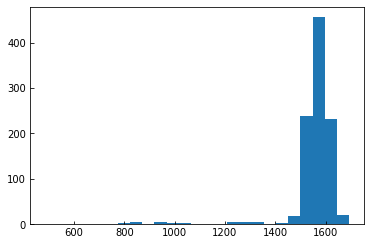

In [66]:
from random import random

#load table
num_random = []
for i in range(1000):
    cat_random = Table.read('CUT_deep_catalogs/DEEP_deep_random_point.fits')

    # choose random spot

    id_rand = int(random() * len(cat_random))
    ra_rand = cat_random[id_rand]['RA']
    dec_rand = cat_random[id_rand]['DEC']
    coord_rand = SkyCoord(ra_rand * u.deg, dec_rand * u.deg)
    coord_random_cat = SkyCoord(np.array(cat_random['RA']) * u.deg, np.array(cat_random['DEC']) * u.deg)

    # draw a circle
    cat_random_cut = cat_random[coord_random_cat.separation(coord_rand).degree < 0.05]

    # count number
    num_random.append(len(cat_random_cut))

plt.hist(num_random, bins=2)

### dealing with tract/patch definition file

In [74]:
import re

In [164]:
patch_file = open('CUT_deep_catalogs/tract_patches/tracts_patches_D-XMM-LSS.txt')

dt = np.dtype((np.float32, 2))
cat_patches = Table(names=['tract','patch','center','corner0','corner1','corner2','corner3','corner4'],
                    dtype=['a4','a4',dt,dt,dt,dt,dt,dt])
data_patch = []
prev_tract = '9999'
prev_patch = '99'
for line in patch_file.readlines():
    if ('Tract' in line) and ('Patch' in line):
        s = re.findall(r"[-+]?\d*\.\d+|\d+", line)  # find the numbers
        tract = s[0]
        patch=s[1]+s[2]
        coord = float(s[-2]),float(s[-1])
        if tract == prev_tract and patch == prev_patch:
            data_patch.append(coord)
        else:
            if len(data_patch)==8:
                cat_patches.add_row(data_patch)
            data_patch = [tract,patch,coord]
            prev_tract = tract
            prev_patch = patch
            
cat_patches.write('CUT_deep_catalogs/tract_patches/XMM-LSS_deep_patches.fits')
            

In [181]:
def find_patch(ra, dec, field='COSMOS_deep'):
    patch_list = []
    cat_patches = Table.read('CUT_deep_catalogs/tract_patches/'+field+'_patches.fits')
    for patch in cat_patches:
        if ra < patch['corner0'][0] and ra > patch['corner1'][0] and dec < patch['corner2'][1] and dec > patch['corner1'][1]:
            patch_list.append([str(patch['tract']), str(patch['patch'])])

    return patch_list

In [190]:
# add patch column
cat_random = Table.read('CUT_deep_catalogs/DEEP_deep_random_point.fits')

tract_list = []
patch_list = []
for i in tqdm(range(len(cat_random))):
    obj = cat_random[i]
    patch_data = find_patch(obj['RA'],obj['DEC'],'DEEP_deep')
    if len(patch_data) != 0:
        tract_list.append(patch_data[-1][0])
        patch_list.append(patch_data[-1][1])
    else:
        tract_list.append('9999')
        patch_list.append('99')        

tract_column = Column(name='tract',dtype='a4',data=tract_list)
patch_column = Column(name='patch',dtype='a4',data=patch_list)
cat_random.add_columns([tract_column,patch_column])
cat_random.write('CUT_deep_catalogs/DEEP_deep_random_point.fits',overwrite=True)

  0%|          | 3526/2351672 [00:56<10:24:27, 62.67it/s]

KeyboardInterrupt: 

  0%|          | 3526/2351672 [01:10<12:57:35, 50.33it/s]

### test variance maps

In [193]:
from astropy.io import fits
from astropy import wcs

In [194]:
im = '/Volumes/LejaySSD/Var/coadd_det_Deep2_MegaCam-u_var.fits'
hdulist = fits.open(im)
w = wcs.WCS(hdulist[0].header)

In [32]:
# batch download weight images

from vos import Client
directory_listing = Client().listdir('vos:clauds/tilesv4')

for i in tqdm(range(len(directory_listing))):
    file = directory_listing[i]
    if 'weight' in file:
        os.system('vcp vos:clauds/tilesv4/' + file + ' /Volumes/LejaySSD/Weight/ --verbose')

100%|██████████| 3255/3255 [2:25:10<00:00,  2.68s/it]  


### test image processing

In [41]:
from astropy.io import fits
from astropy.wcs import WCS

In [95]:
data=img[0].data
w = WCS(img[0].header)
img = fits.open('/Volumes/LejaySSD/Weight/Mega-uS_10054_0c0.weight.fits')

pix_coord = w.all_world2pix(149.55,2.9,0)
print(pix_coord[0])
data[int(pix_coord[0]),int(pix_coord[1])]

1096.3910878214047


12.853811

### make region files

In [116]:
file = open('/Users/lejay/Downloads/CLAUDS_verts/ELAIS_verts_tm.txt')
out_file = open('CUT_deep_catalogs/region_files/ELAIS_deep_uregion_tm.reg','w')
vertices = file.readlines()
out_file.write('fk5 \n')
vertices_string = ''
for vertex in vertices[:-1]:
    vertex = vertex.rstrip().split()
    vertices_string += vertex[0]+','+vertex[1]+','
    
vertex = vertices[-1].rstrip().split()
vertices_string += vertex[0]+','+vertex[1]
polygon_string = 'polygon('+vertices_string+')'
out_file.write(polygon_string)
out_file.close()
file.close()

In [259]:
t = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point_patches.fits')
print(len(t))
t.info()
t.add_index('tract')
type(t.loc_indices['9812'])

2445620
<Table length=2445620>
 name   dtype 
------ -------
    RA float64
   DEC float64
inside float64
  MASK float64
 tract  bytes8
 patch  bytes8
weight float32
   var float32


list

In [30]:
cat = Table.read('CUT_deep_catalogs/v2_matched_centrals/central_COSMOS_deep_0.8.fits')
cat = cat[cat['TRACT'] == 9813]
# cat = cat[cat['PATCH'] == '0,1']

In [14]:
from astropy.io import fits
im = 'CUT_deep_catalogs/calexp-HSC-I-9813-5,5.fits'
tract = im.split('-')[-2]
patch = im.split('-')[-1].replace('.fits', '')

In [3]:
cat = Table.read('CUT_deep_catalogs/deep2_photoz_v2.fits')

for gal in cat:
    gal['ID']  = gal['ID']
    
cat.write('CUT_deep_catalogs/deep2_photoz_v2.fits',overwrite=True)

### Processing of new catalogs (from Vincent Picouet)
insert inside_u and inside_us flag (NOT removing FLAG_FIELD_BINARY flag)

In [507]:
# cat_dir = 'clauds_cat_v2020/'  # v2 cat
# version = 'v2_v200930'

# cat_dir = '/Volumes/LejaySSD/v4_cats/'  #v4 cat
# version = 'v4_v201129'

cat_dir = '/Volumes/LejaySSD/v6_cats/'  #v6 cat
version = 'v6_v201223'

for cat_name in ['COSMOS_deep','XMM-LSS_deep','DEEP_deep','ELAIS_deep']:
    print(cat_name)
    cat = Table.read(cat_dir+cat_name+'_'+version+'.fits')
    
    inside_u_col = Column(name='inside_u',data=cat['FLAG_FIELD_BINARY'][:,1])
    inside_us_col = Column(name='inside_uS',data=cat['FLAG_FIELD_BINARY'][:,2])
    
    cat.add_columns([inside_u_col,inside_us_col])
    cat.write(cat_dir+cat_name+'_'+version+'.fits', overwrite=True)

COSMOS_deep
XMM-LSS_deep
DEEP_deep
ELAIS_deep


### comparison of z's and masses

In [64]:
import matplotlib as mpl
import seaborn as sns

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

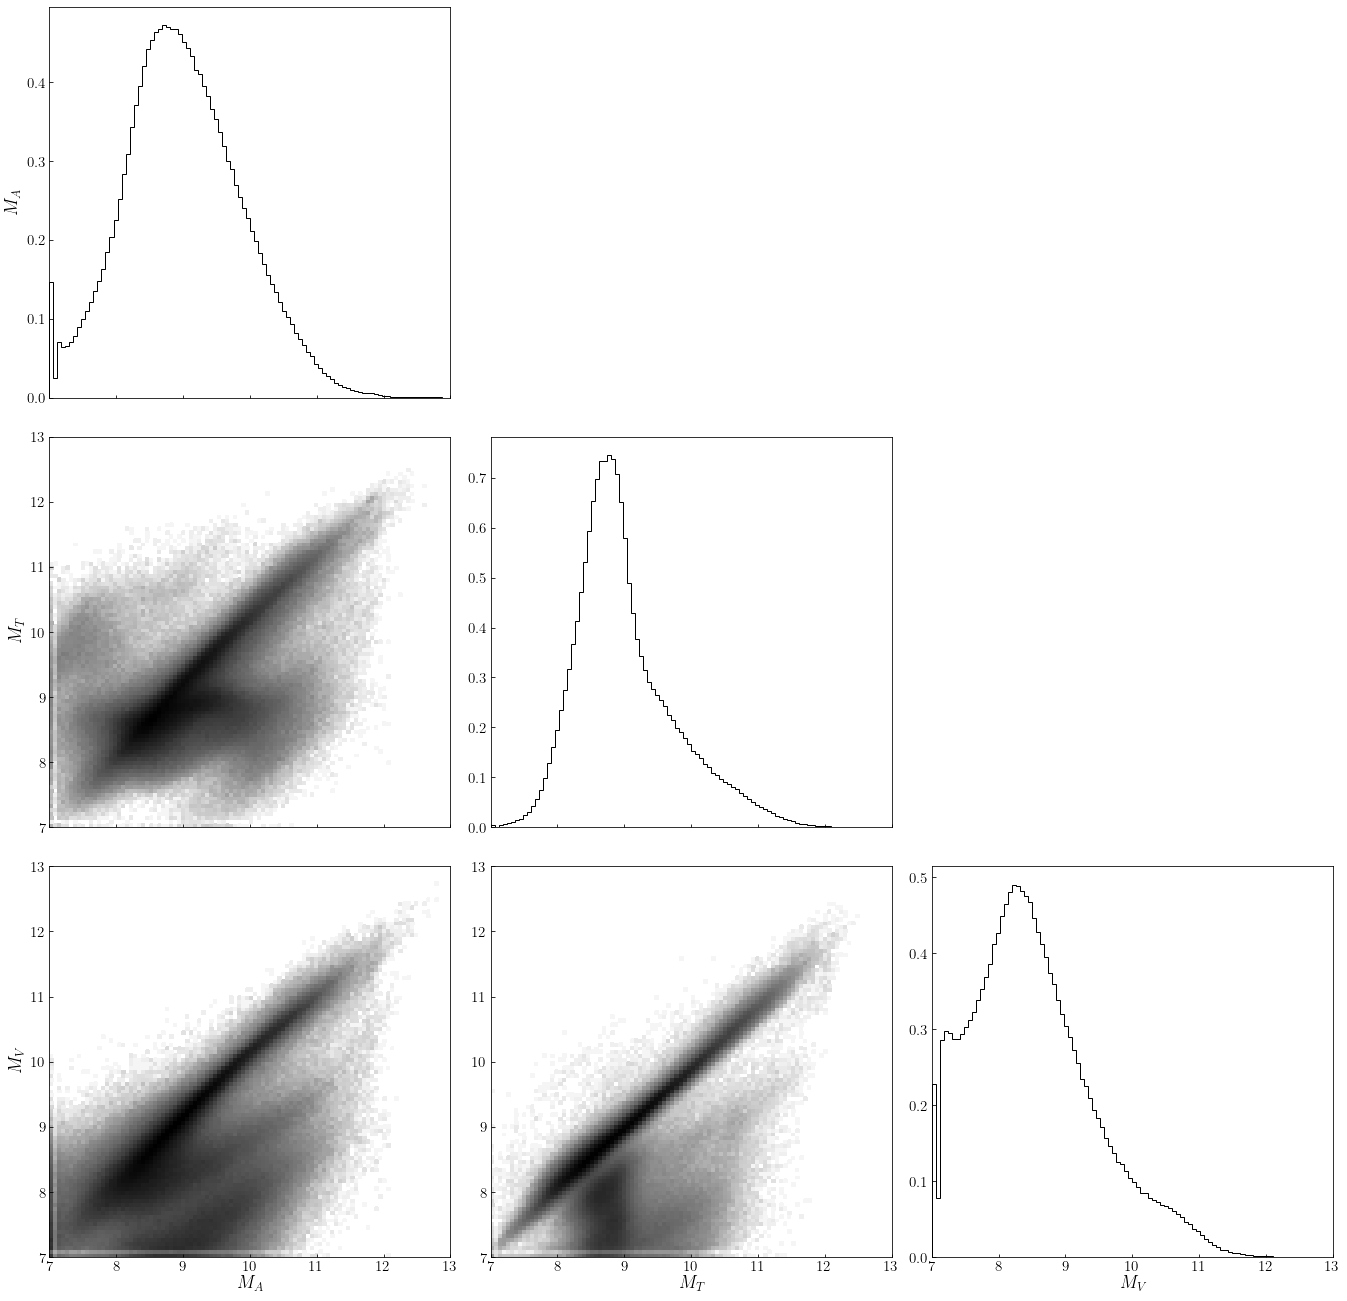

In [74]:
cat = Table.read('CUT_deep_catalogs/cosmos_combined_ATV.fits')

fig, axs = plt.subplots(3, 3, figsize=(23,23),sharex=True)

# histograms
axs[0][0].hist(cat['MASS_MED_1'], bins=100, range=(7,13),density=True,color='k',histtype='step')
axs[1][1].hist(cat['MASS_MED_new'], bins=100, range=(7,13),density=True,color='k',histtype='step')
axs[2][2].hist(cat['MASS_MED_2'], bins=100, range=(7,13),density=True,color='k',histtype='step')

# correlations

axs[2][0].hist2d(cat['MASS_MED_1'], cat['MASS_MED_2'], bins=100,
                 range=[[7,13],[7,13]],norm=mpl.colors.LogNorm(), cmap='Greys')
axs[2][1].hist2d(cat['MASS_MED_new'], cat['MASS_MED_2'], bins=100,
                 range=[[7,13],[7,13]],norm=mpl.colors.LogNorm(), cmap='Greys')
axs[1][0].hist2d(cat['MASS_MED_1'], cat['MASS_MED_new'], bins=100,
                 range=[[7,13],[7,13]],norm=mpl.colors.LogNorm(), cmap='Greys')

axs[2][0].set_xlabel(r'$M_A$',fontsize=18)
axs[2][1].set_xlabel(r'$M_T$',fontsize=18)
axs[2][2].set_xlabel(r'$M_V$',fontsize=18)

axs[0][0].set_ylabel(r'$M_A$',fontsize=18)
axs[1][0].set_ylabel(r'$M_T$',fontsize=18)
axs[2][0].set_ylabel(r'$M_V$',fontsize=18)


fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.1)
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])

/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


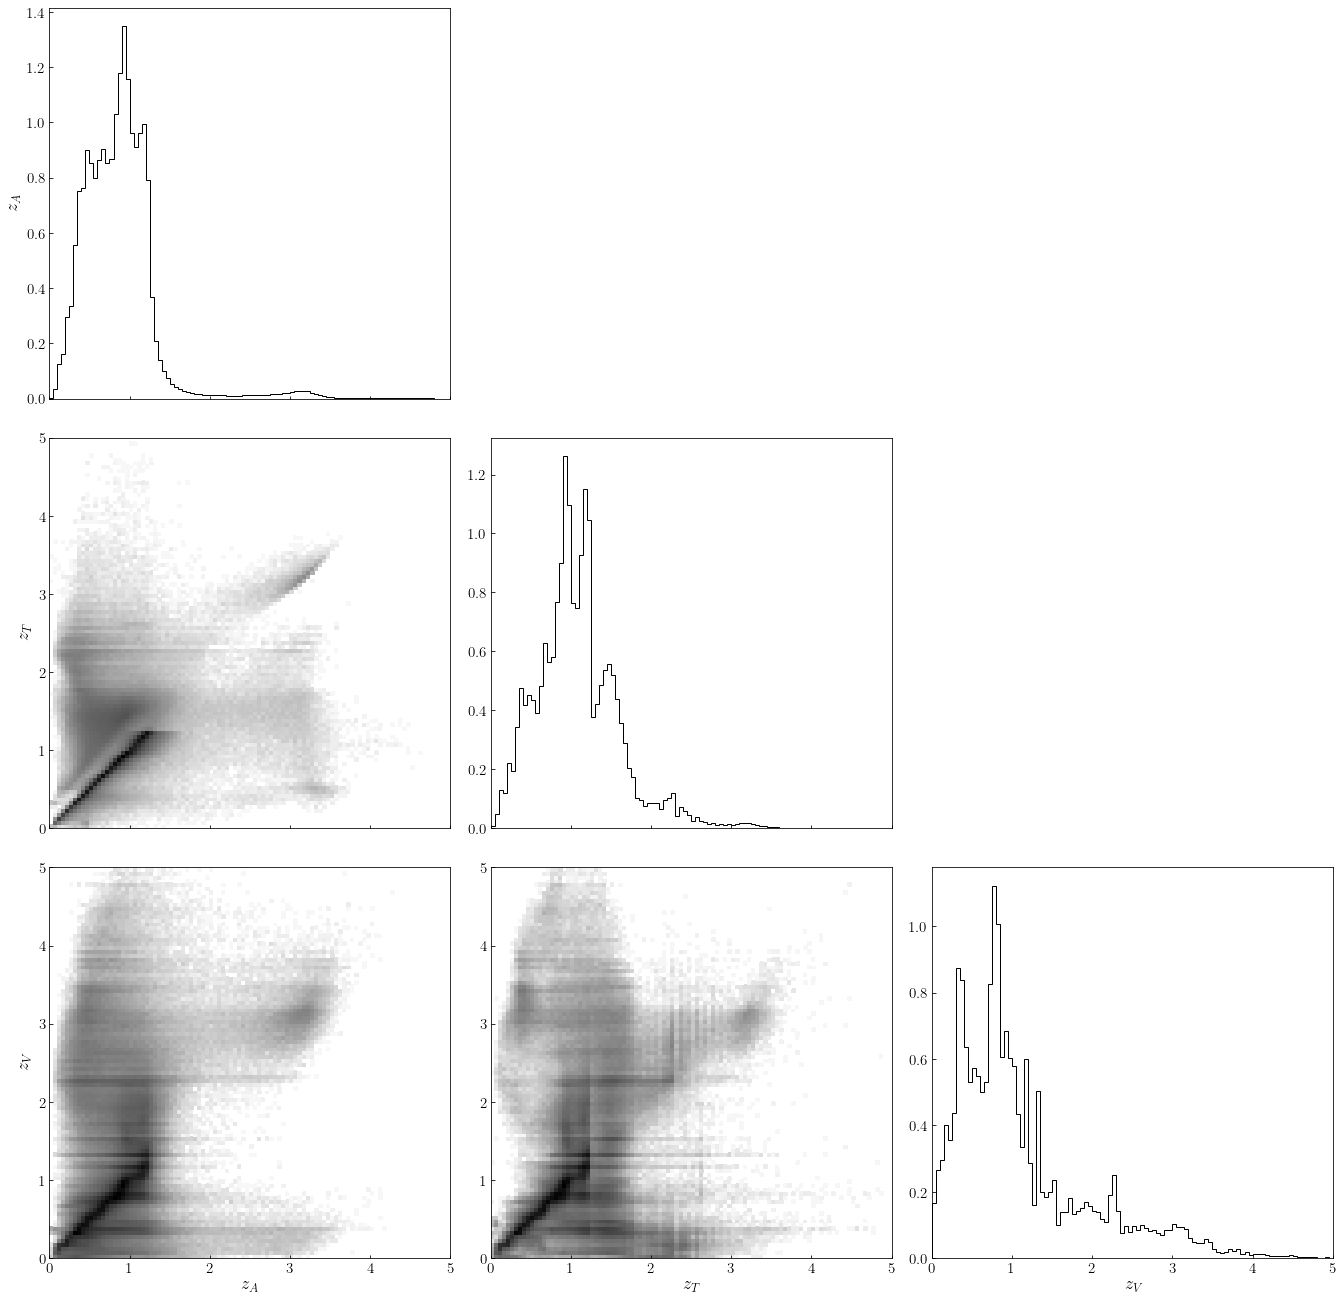

In [75]:
cat = Table.read('CUT_deep_catalogs/cosmos_combined_ATV.fits')

fig, axs = plt.subplots(3, 3, figsize=(23,23),sharex=True)

# histograms
axs[0][0].hist(cat['zKDEMedian'], bins=100, range=(0,5),density=True,color='k',histtype='step')
axs[1][1].hist(cat['Z_BEST_BC03'], bins=100, range=(0,5),density=True,color='k',histtype='step')
axs[2][2].hist(cat['Z_BEST'], bins=100, range=(0,5),density=True,color='k',histtype='step')

# correlations

axs[2][0].hist2d(cat['zKDEMedian'], cat['Z_BEST'], bins=100,
                 range=[[0,5],[0,5]],norm=mpl.colors.LogNorm(), cmap='Greys')
axs[2][1].hist2d(cat['Z_BEST_BC03'], cat['Z_BEST'], bins=100,
                 range=[[0,5],[0,5]],norm=mpl.colors.LogNorm(), cmap='Greys')
axs[1][0].hist2d(cat['zKDEMedian'], cat['Z_BEST_BC03'], bins=100,
                 range=[[0,5],[0,5]],norm=mpl.colors.LogNorm(), cmap='Greys')

axs[2][0].set_xlabel(r'$z_A$',fontsize=18)
axs[2][1].set_xlabel(r'$z_T$',fontsize=18)
axs[2][2].set_xlabel(r'$z_V$',fontsize=18)

axs[0][0].set_ylabel(r'$z_A$',fontsize=18)
axs[1][0].set_ylabel(r'$z_T$',fontsize=18)cf
axs[2][0].set_ylabel(r'$z_V$',fontsize=18)


fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.1)
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])

### demograhpics on the new catalogs
NUVrK


In [4]:
# field
cat_name = 'COSMOS_deep'

# 1) Anneya's catalog
cat_a = Table.read('CUT_deep_catalogs/s16a_'+cat_name+'_masterCat.fits')
cat_a = cat_a
cat_a = cat_a[cat_a['inside']==True]
cat_a_gal = cat_a[cat_a['preds_median']<0.89]
# cat_a_bright = cat_a_inside[cat_a_inside['i']<26.5]

# 2) Thibaud's catalog
cat_t = Table.read('CUT_deep_catalogs/UV_CLAUDS_HSC_S16A_'+cat_name+'.fits')
cat_t= cat_t
cat_t_gal = cat_t[cat_t['CLASS']<10]
# cat_t_bright = cat_t_inside[cat_t_inside['i']<26.5]

# 3) Vincent's catalog
cat_v = Table.read('clauds_cat_v2020/'+cat_name+'_v2_v200930.fits')
cat_v = cat_v[cat_v['MASK']==0]
cat_v = cat_v[cat_v['FLAG_FIELD_BINARY'][:,1]==True]
cat_v_gal = cat_v[cat_v['OBJ_TYPE'] == 0]
# cat_v_bright = cat_v_inside[cat_v_inside['i']<26.5]

# 4) Vincent's COSMOS_uddd catalog
cat_v_uddd = Table.read('clauds_cat_v2020/COSMOS_UDD_Ugrizy_v3_NOV2020.fits')

In [5]:
# 5) Vincent's catalog, v4
cat_v4 = Table.read('/Volumes/LejaySSD/v4_cats/'+cat_name+'_v4_v201129.fits')
cat_v4 = cat_v4[cat_v4['MASK']==0]
cat_v4 = cat_v4[cat_v4['FLAG_FIELD_BINARY'][:,1]==True]
cat_v4_gal = cat_v4[cat_v4['OBJ_TYPE'] == 0]

# 6) Vincent's COSMOS_uddd catalog matched with v2 COSMOS deep+uddd catalog
# _1: params from deep+uddd catalog
# _2: params from uddd only (Ugrizy) catalog
cat_v_uddd_and_deep = Table.read('clauds_cat_v2020/COSMOS_v3_NOV2020_and_v2_v200930.fits')
cat_v_uddd_and_deep_unmasked = cat_v_uddd_and_deep[cat_v_uddd_and_deep['MASK']==0]
cat_v_uddd_and_deep_inside = cat_v_uddd_and_deep_unmasked[cat_v_uddd_and_deep_unmasked['FLAG_FIELD_BINARY'][:,1]==True]
cat_v_uddd_and_deep_gal = cat_v_uddd_and_deep_inside[cat_v_uddd_and_deep_inside['OBJ_TYPE'] == 0]

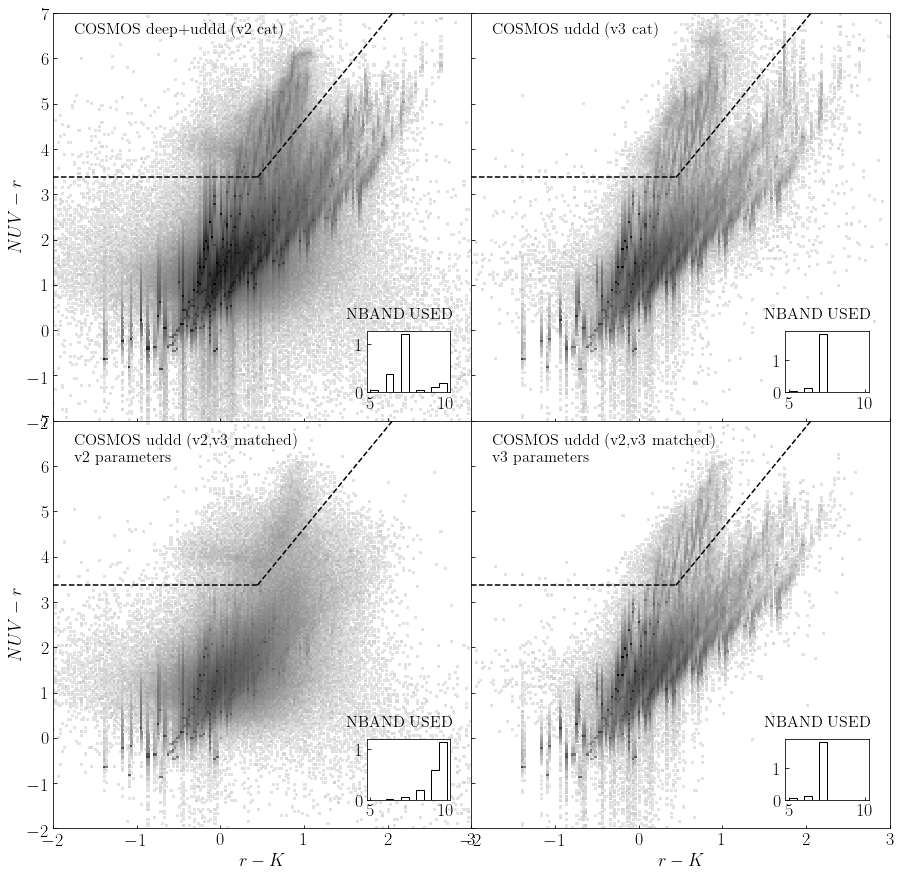

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(15,15),sharex=True, sharey=True)

for i in range(2):
    for j in range(2):
        axs[i][j].plot([-2,(3.372-2.368)/2.25],[3.372,3.372],'--k')
        axs[i][j].plot([(3.372-2.368)/2.25,3],[3.372,3*2.25+2.368],'--k')

# COSMOS deep+uddd
axs[0][0].hist2d(cat_v_gal['MAG_ABS_r'] - cat_v_gal['MAG_ABS_Ks'], cat_v_gal['MAG_ABS_NUV'] - cat_v_gal['MAG_ABS_r'], bins=200,
           range=[[-2,3],[-2,7]], vmin=0.1, vmax=10000,
           norm=mpl.colors.LogNorm(), cmap='Greys')
ax_insert = axs[0][0].inset_axes([0.75, 0.07, 0.2, 0.15])
ax_insert.hist(cat_v_gal['NBAND_USED'], range=(5,10),histtype='step',color='k',density=True)

# atalog in COSMOS_uddd (Ugrizy)
axs[0][1].hist2d(cat_v_uddd['MAG_ABS_r'] - cat_v_uddd['MAG_ABS_Ks'],cat_v_uddd['MAG_ABS_NUV'] - cat_v_uddd['MAG_ABS_r'], bins=200,
           range=[[-2,3],[-2,7]],vmin=0.1, vmax=10000,
           norm=mpl.colors.LogNorm(), cmap='Greys')
ax_insert = axs[0][1].inset_axes([0.75, 0.07, 0.2, 0.15])
ax_insert.hist(cat_v_uddd['NBAND_USED'], range=(5,10), histtype='step',color='k',density=True)

# matched catalog in COSMOS_uddd (UgrizyJHK)
# _1: params from deep+uddd catalog
# _2: params from uddd only (Ugrizy) catalog
axs[1][0].hist2d(cat_v_uddd_and_deep_gal['MAG_ABS_r_1'] - cat_v_uddd_and_deep_gal['MAG_ABS_Ks_1'],cat_v_uddd_and_deep_gal['MAG_ABS_NUV_1'] - cat_v_uddd_and_deep_gal['MAG_ABS_r_1'], bins=200,
           range=[[-2,3],[-2,7]],vmin=0.1, vmax=10000,
           norm=mpl.colors.LogNorm(), cmap='Greys')
ax_insert = axs[1][0].inset_axes([0.75, 0.07, 0.2, 0.15])
ax_insert.hist(cat_v_uddd_and_deep['NBAND_USED_1'], range=(5,10), histtype='step',color='k',density=True)

# matched catalog in COSMOS_uddd (Ugrizy)
axs[1][1].hist2d(cat_v_uddd_and_deep_gal['MAG_ABS_r_2'] - cat_v_uddd_and_deep_gal['MAG_ABS_Ks_2'],cat_v_uddd_and_deep_gal['MAG_ABS_NUV_2'] - cat_v_uddd_and_deep_gal['MAG_ABS_r_2'], bins=200,
           range=[[-2,3],[-2,7]],vmin=0.1, vmax=10000,
           norm=mpl.colors.LogNorm(), cmap='Greys')
ax_insert = axs[1][1].inset_axes([0.75, 0.07, 0.2, 0.15])
ax_insert.hist(cat_v_uddd_and_deep['NBAND_USED_2'], range=(5,10), histtype='step',color='k',density=True)

axs[0][0].annotate('COSMOS deep+uddd (v2 cat)',xy=([0.05,0.95]),xycoords='axes fraction',fontsize=16)
axs[0][1].annotate('COSMOS uddd (v3 cat)',xy=([0.05,0.95]),xycoords='axes fraction',fontsize=16)
axs[1][0].annotate('COSMOS uddd (v2,v3 matched)\n v2 parameters',xy=([0.05,0.9]),xycoords='axes fraction',fontsize=16)
axs[1][1].annotate('COSMOS uddd (v2,v3 matched)\n v3 parameters',xy=([0.05,0.9]),xycoords='axes fraction',fontsize=16)

axs[0][0].annotate('NBAND USED',xy=([0.7,0.25]),xycoords='axes fraction',fontsize=16)
axs[0][1].annotate('NBAND USED',xy=([0.7,0.25]),xycoords='axes fraction',fontsize=16)
axs[1][0].annotate('NBAND USED',xy=([0.7,0.25]),xycoords='axes fraction',fontsize=16)
axs[1][1].annotate('NBAND USED',xy=([0.7,0.25]),xycoords='axes fraction',fontsize=16)

axs[1][0].set_xlabel(r'$r-K$',fontsize=18)
axs[1][1].set_xlabel(r'$r-K$',fontsize=18)
axs[0][0].set_ylabel(r'$NUV-r$',fontsize=18)
axs[1][0].set_ylabel(r'$NUV-r$',fontsize=18)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

plt.savefig('/Users/lejay/Desktop/NUVrK_6band_9band.pdf')
plt.show()

### SF/Q classification

In [6]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
from astropy.cosmology import Planck13
from sklearn.neighbors import KernelDensity
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import pickle

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


In [7]:
# match between COSMOS_uddd and COSMOS2015 (1" match)
# _1 from COSMOS2015
# _2 from CLAUDS/HSC COSMOS_uddd
cat_lv_added = Table.read('COSMOS2015_Laigle_Vincent_uddd_added.fits')  
cat_lv_added = cat_lv_added[cat_lv_added['MU']>-99]
cat_lv_added = cat_lv_added[cat_lv_added['MR']>-99]
cat_lv_added = cat_lv_added[cat_lv_added['MZ']>-99]
cat_lv_added = cat_lv_added[cat_lv_added['MK']>-99]
cat_lv_added = cat_lv_added[cat_lv_added['MNUV']>-99]

# CLAUDS/HSC selection
# cat_lv_unmasked = cat_lv_added[cat_lv_added['MASK']==0]
# cat_lv_inside = cat_lv_unmasked[cat_lv_unmasked['FLAG_FIELD_BINARY'][:,1]==True]
# cat_lv_gal = cat_lv_inside[cat_lv_inside['OBJ_TYPE'] == 0]
# cat_lv_gal = cat_lv_gal[cat_lv_gal['NBAND_USED']==7]  # only 6-band derived parameters


# COSMOS2015 selection
cat_lv_added = cat_lv_added[cat_lv_added['FLAG_PETER']==0]  # unmasked
cat_lv_gal = cat_lv_added[cat_lv_added['TYPE']==0]  # galaxy

train the SVM classifiers / selection box

In [8]:
def gv_boundary(color1,z):
    t_l = Planck13.lookback_time(z)  # Planck 2013 lookback time (Gyr)
    color2_1 = 3.272 - 0.029*t_l.value
    color2_2 = 2.25*color1 +2.268 - 0.029*t_l.value
    return np.maximum(color2_1, color2_2)

def gv_boundary_2(rk, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*rk + ic_2
    return np.maximum(nuv_1, nuv_2)

def fraction_score(cat, ic_1, ic_2, slope):
    rk = cat['MAG_ABS_r'] - cat['MAG_ABS_Ks']
    delta_gv = cat['MAG_ABS_NUV'] - cat['MAG_ABS_r'] - gv_boundary_2(rk, ic_1, ic_2, slope)
    
    q = delta_gv > 0
    sf = delta_gv < 0
    
    true_q = cat_lv_gal_z['CLASS']==0      
    true_sf = cat_lv_gal_z['CLASS']!=0
    
    FP = sum(true_sf*q)  # false positive
    TP = sum(true_q*q)   # true positive
    FN = sum(true_q*sf)  # false negative
    TN = sum(true_sf*sf) # true negative
    
#     print(FP,TP,FN,TN,len(rk))
    
    fc = FP/(TP+FP)
    fm = FN/(TP+FN)
    return fc+fm+abs(fc-fm)

In [9]:
ic_1 = np.linspace(2.0, 3.5, 10)
ic_2 = np.linspace(2., 3.3, 13)
slope = np.linspace(0, 3, 15)

ic_1_mesh, ic_2_mesh, slope_mesh = np.meshgrid(ic_1, ic_2, slope, indexing='ij')

In [500]:
zs = [0.4, 0.6, 0.8]
mass_limits = [9.5, 10, 10.5 ,11.0, 13.0]

best_box = []
for i in range(12):
    row = i // 3
    col = i % 3
    
    z = zs[col]    
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']>mass_limits[row]]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']<mass_limits[row+1]]
    print(z,mass_limits[row],mass_limits[row+1])
    
    scores = []
    for i in range(len(ic_1_mesh.ravel())):
        score = fraction_score(cat_lv_gal_z, ic_1_mesh.ravel()[i], ic_2_mesh.ravel()[i], slope_mesh.ravel()[i])
        if score >= 0:
            scores.append(score)
        else:
            scores.append(999.)
    
    best_id = np.argmin(np.array(scores))
    ic_1,ic_2,slope = ic_1_mesh.ravel()[best_id], ic_2_mesh.ravel()[best_id], slope_mesh.ravel()[best_id]
    best_box.append([ic_1,ic_2,slope])
    print(row,col,best_id,[ic_1,ic_2,slope])
    print(' ')
    
np.save('best_select_box.npy',np.array(best_box))

0.4 9.5 10
0 0 124 [2.0, 2.8666666666666667, 0.8571428571428571]
 
0.6 9.5 10
0 1 1419 [3.1666666666666665, 2.325, 1.9285714285714284]
 
0.8 9.5 10
0 2 1893 [3.5, 2.9749999999999996, 0.6428571428571428]
 
0.4 10 10.5
1 0 1280 [3.0, 2.7583333333333333, 1.0714285714285714]
 
0.6 10 10.5
1 1 1671 [3.333333333333333, 2.7583333333333333, 1.2857142857142856]
 
0.8 10 10.5
1 2 168 [2.0, 3.1916666666666664, 0.6428571428571428]
 
0.4 10.5 11.0
2 0 154 [2.0, 3.083333333333333, 0.8571428571428571]
 
0.6 10.5 11.0
2 1 183 [2.0, 3.3, 0.6428571428571428]
 
0.8 10.5 11.0
2 2 1791 [3.5, 2.216666666666667, 1.2857142857142856]
 
0.4 11.0 13.0


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


3 0 168 [2.0, 3.1916666666666664, 0.6428571428571428]
 
0.6 11.0 13.0
3 1 168 [2.0, 3.1916666666666664, 0.6428571428571428]
 
0.8 11.0 13.0
3 2 1878 [3.5, 2.8666666666666667, 0.6428571428571428]
 


AttributeError: 'list' object has no attribute 'write'

In [25]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    out = ax.contour(xx, yy, Z, **params)
    return out

In [37]:
zs = [0.4, 0.6, 0.8]
mass_limits = [9.5,10,10.5,11.0,13.0]
for i in range(12):
    row = i // 3
    col = i % 3
    
    z = zs[col]    
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']>mass_limits[row]]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']<mass_limits[row+1]]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['Z_BEST']-cat_lv_gal_z['ZPDF'])<0.15]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['MASS_MED_2']-cat_lv_gal_z['MASS_MED_1'])<0.25]
    
    # construct input and labels for SVM
    rk = cat_lv_gal_z['MAG_ABS_r'] - cat_lv_gal_z['MAG_ABS_Ks']
    nuvr = cat_lv_gal_z['MAG_ABS_NUV'] - cat_lv_gal_z['MAG_ABS_r']
    x=np.c_[np.array(rk),np.array(nuvr)]  # nuv r k colors as inputs
    y=cat_lv_gal_z['CLASS']==0            # COSMOS2015 training labels
    
    # 5-fold CV for best hyperparameter gamma and C
    svm_cv=GridSearchCV(svm.SVC(kernel='rbf'),{'gamma': np.linspace(0.05, 1, 50), 'C' : np.linspace(0.01,0.5,50)}, 
                    scoring={'AUC': 'roc_auc'}, refit='AUC', cv = 5, return_train_score=True)
    
    random_ids = np.random.randint(low=0,high=len(cat_lv_gal_z),size=100)
    svm_cv.fit(x[random_ids],y[random_ids])
    gamma = svm_cv.best_params_['gamma']
    C = svm_cv.best_params_['C']
    print('gamma=%.3f, C=%.3f, mean AUC of best model: %.3f' % (gamma,C,svm_cv.best_score_))
    
    # train the SVM model
    clf = svm.SVC(kernel='rbf', gamma=gamma, C=C,  probability=True)   # the svm classifier
    clf.fit(x, y)

    # save the SVM estimator through pickle
    pkl_filename = 'pickle_svm_'+str(row)+'_'+str(col)+'.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clf, file)
    

gamma=0.864, C=0.360, mean AUC of best model: 0.987
gamma=0.186, C=0.010, mean AUC of best model: 0.941
gamma=0.050, C=0.010, mean AUC of best model: 0.963
gamma=0.224, C=0.010, mean AUC of best model: 0.984
gamma=0.050, C=0.100, mean AUC of best model: 0.939
gamma=0.108, C=0.480, mean AUC of best model: 0.949
gamma=0.535, C=0.140, mean AUC of best model: 0.949
gamma=0.748, C=0.460, mean AUC of best model: 0.931
gamma=0.263, C=0.410, mean AUC of best model: 0.921
gamma=0.069, C=0.010, mean AUC of best model: 0.831
gamma=0.205, C=0.010, mean AUC of best model: 0.898
gamma=0.069, C=0.010, mean AUC of best model: 0.957


-0.9350000000000023 2.4719999999999978
-0.15500000000000114 6.216000000000001


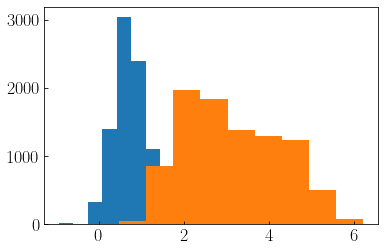

In [21]:
z = 0.8
cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']>9.5]

rk = cat_lv_gal_z['MAG_ABS_r'] - cat_lv_gal_z['MAG_ABS_Ks']
plt.hist(rk)
print(min(rk),max(rk))

nuvr = cat_lv_gal_z['MAG_ABS_NUV'] - cat_lv_gal_z['MAG_ABS_r']
plt.hist(nuvr)
print(min(nuvr),max(nuvr))

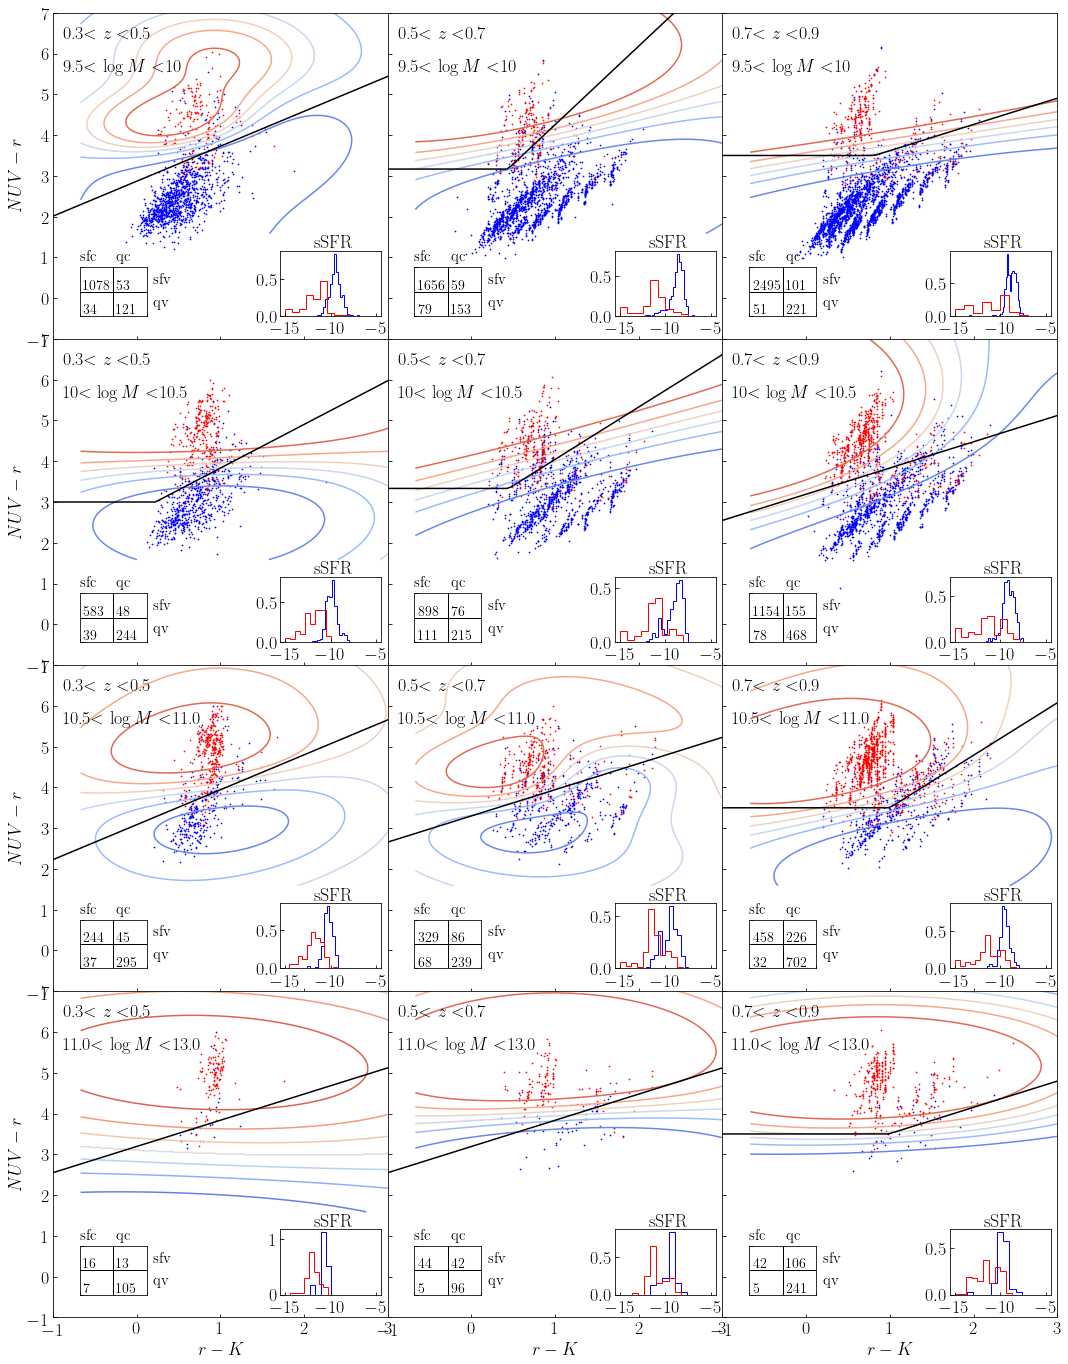

In [38]:
fig, axs = plt.subplots(4, 3, figsize=(18,24),sharex=True, sharey=True)

zs = [0.4, 0.6, 0.8]
mass_limits = [9.5,10,10.5,11.0,13.0]
inset_type = 'ssfr'

# (in cat_lv_gal) _1 from COSMOS2015
# (in cat_lv_gal) _2 from CLAUDS/HSC COSMOS_uddd

best_box = np.load('best_select_box.npy')

for i in range(12):
    row = i // 3
    col = i % 3
    
    z = zs[col]
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']>mass_limits[row]]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']<mass_limits[row+1]]
    
    # select only consistent z/m objects
#     print(len(cat_lv_gal_z))
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['Z_BEST']-cat_lv_gal_z['ZPDF'])<0.15]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['MASS_MED_2']-cat_lv_gal_z['MASS_MED_1'])<0.25]

    
    axs[3][col].set_xlabel(r'$r-K$',fontsize=18)
    axs[row][0].set_ylabel(r'$NUV-r$',fontsize=18)
    axs[row][col].set_xlim([-1,3])
    axs[row][col].set_ylim([-1,7])
    
    # draw the selection boundary
    rk_draw = np.linspace(-2,3,100)
    nuv_draw_mid = gv_boundary_2(rk_draw,best_box[i][0],best_box[i][1],best_box[i][2])
    axs[row][col].plot(rk_draw, nuv_draw_mid, color='k')
    
    
    # Load trained SVM model from file
    with open('pickle_svm_'+str(row)+'_'+str(col)+'.pkl', 'rb') as file:
        clf_load = pickle.load(file)
    xx, yy = make_meshgrid(rk, nuvr)
    plot_contours(axs[row][col], clf_load, xx, yy, cmap=plt.cm.coolwarm_r)
    
    # Laigle+2016 NUVrK classification
    cat_lv_gal_z_sf = cat_lv_gal_z[cat_lv_gal_z['CLASS']==1]  #sf
    cat_lv_gal_z_q = cat_lv_gal_z[cat_lv_gal_z['CLASS']==0]  #q
    
    # NUVrK but with color-coding from Laigle+2016 NUVrK classification
    axs[row][col].scatter(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_Ks'], 
                          cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'],
                         s=0.5,c='b')
    axs[row][col].scatter(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_Ks'], 
                          cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'],
                         s=0.5,c='r')
    
    
    rk_sf = np.array(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_Ks'])
    rk_q = np.array(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_Ks']) 
    delta_gv_sf = cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r']-gv_boundary(rk_sf,z)
    delta_gv_q = cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r']-gv_boundary(rk_q,z)
    
    # inset 1: dGV or sSFR
    ax_insert = axs[row][col].inset_axes([0.68, 0.07, 0.3, 0.2])
    if inset_type == 'dgv':   # Delta_GV but seprated by Laigle+2016 NUVrK classification
        ax_insert.hist(delta_gv_sf,range=(-2,2),bins='scott',histtype='step',color='b',density=True)
        ax_insert.hist(delta_gv_q,range=(-2,2),bins='scott',histtype='step',color='r',density=True)
        axs[row][col].annotate('$\Delta$GV',xy=([0.78,0.28]),xycoords='axes fraction',fontsize=18)
    elif inset_type == 'ssfr':   # ssfr seprated by Laigle+2016 NUVrK classification
        ax_insert.hist(cat_lv_gal_z_sf['SSFR_MED_2'],range=(-15,-5),bins='scott',histtype='step',color='b',density=True)
        ax_insert.hist(cat_lv_gal_z_q['SSFR_MED_2'],range=(-15,-5),bins='scott',histtype='step',color='r',density=True)
        axs[row][col].annotate('sSFR',xy=([0.78,0.28]),xycoords='axes fraction',fontsize=18)
        
    axs[row][col].annotate(str(round(z-0.1,1))+"$<z<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
    axs[row][col].annotate(str(mass_limits[row])+"$<\log M<$"+str(mass_limits[row+1]),xy=([0.03,0.82]),xycoords='axes fraction',fontsize=18)
    
    # contingency table (inset plot 2)
    # clauds_hsc_class _ cosmos_class
    sf_sf = len(cat_lv_gal_z_sf[delta_gv_sf<0])
    q_q = len(cat_lv_gal_z_q[delta_gv_q>0])
    sf_q = len(cat_lv_gal_z_q[delta_gv_q<0])
    q_sf = len(cat_lv_gal_z_sf[delta_gv_sf>0])
    
    ax_insert2 = axs[row][col].inset_axes([0.08, 0.07, 0.2, 0.15])
    ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
    ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
    
    axs[row][col].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('sfv',xy=([0.3,0.17]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('qv',xy=([0.3,0.1]),xycoords='axes fraction',fontsize=15)
    
    ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
    ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
    ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
    ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
    
    ax_insert2.set_xlim([-1,1])
    ax_insert2.set_ylim([-1,1])
    ax_insert2.set_yticklabels([])
    ax_insert2.set_xticklabels([])
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

plt.savefig('/Users/lejay/Desktop/NUVrK.pdf')
plt.show()


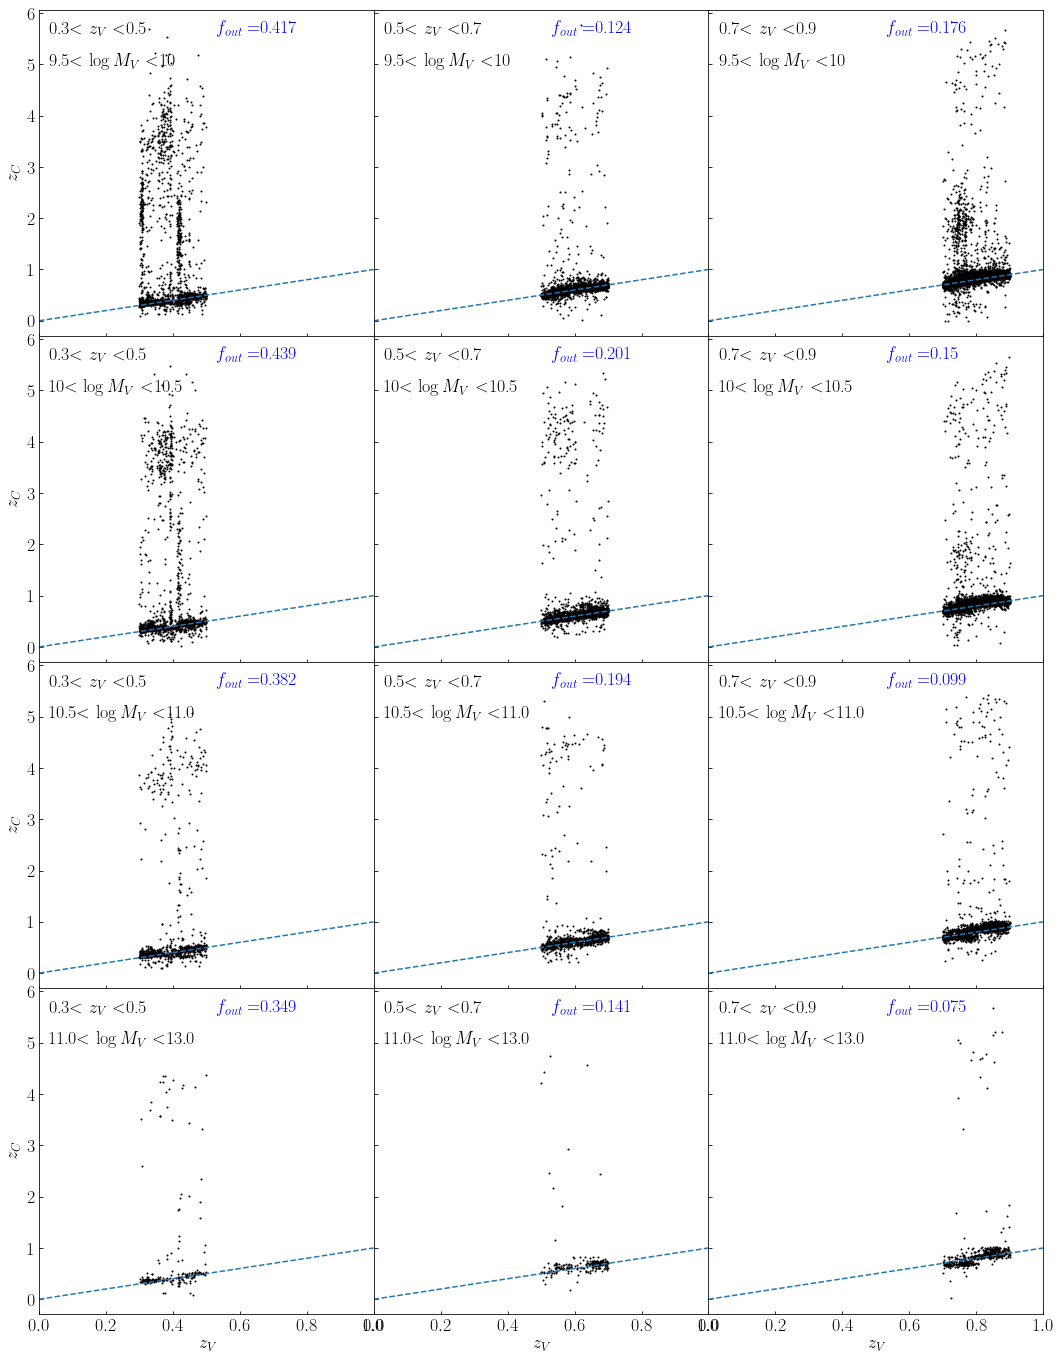

In [22]:
# z vs z plot
fig, axs = plt.subplots(4, 3, figsize=(18,24),sharex=True, sharey=True)

zs = [0.4, 0.6, 0.8]
mass_limits = [9.5,10,10.5,11.0,13.0]

# _1: params from deep+uddd catalog
# _2: params from uddd only (Ugrizy) catalog
cat_gal = cat_v_uddd_and_deep_gal.copy()

for i in range(12):
    row = i // 3
    col = i % 3
    
    z = zs[col]
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']>mass_limits[row]]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']<mass_limits[row+1]]
    
    # 
    axs[row][col].scatter(cat_lv_gal_z['Z_BEST'],cat_lv_gal_z['ZPDF'],s=1,color='k')
    axs[row][col].set_xlim([0,1])
    axs[row][col].plot([0,1],[0,1],'--')
    
    axs[row][col].annotate(str(round(z-0.1,1))+"$<z_V<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
    axs[row][col].annotate(str(mass_limits[row])+"$<\log M_V<$"+str(mass_limits[row+1]),xy=([0.03,0.82]),xycoords='axes fraction',fontsize=18)
    
    axs[3][col].set_xlabel(r'$z_V$',fontsize=18)
    axs[row][0].set_ylabel(r'$z_C$',fontsize=18)
    
    # outlier rate
    outlier_cut = abs(cat_lv_gal_z['Z_BEST']-cat_lv_gal_z['ZPDF'])>0.2/*cat_lv_gal_z['Z_BEST']
    cat_lv_gal_z_outlier = cat_lv_gal_z[outlier_cut]
    outlier_rate = len(cat_lv_gal_z_outlier)/len(cat_lv_gal_z)
    axs[row][col].annotate(r'$f_{out}=$'+str(round(outlier_rate,3)),xy=([0.53,0.92]),xycoords='axes fraction',fontsize=18,color='b')
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)


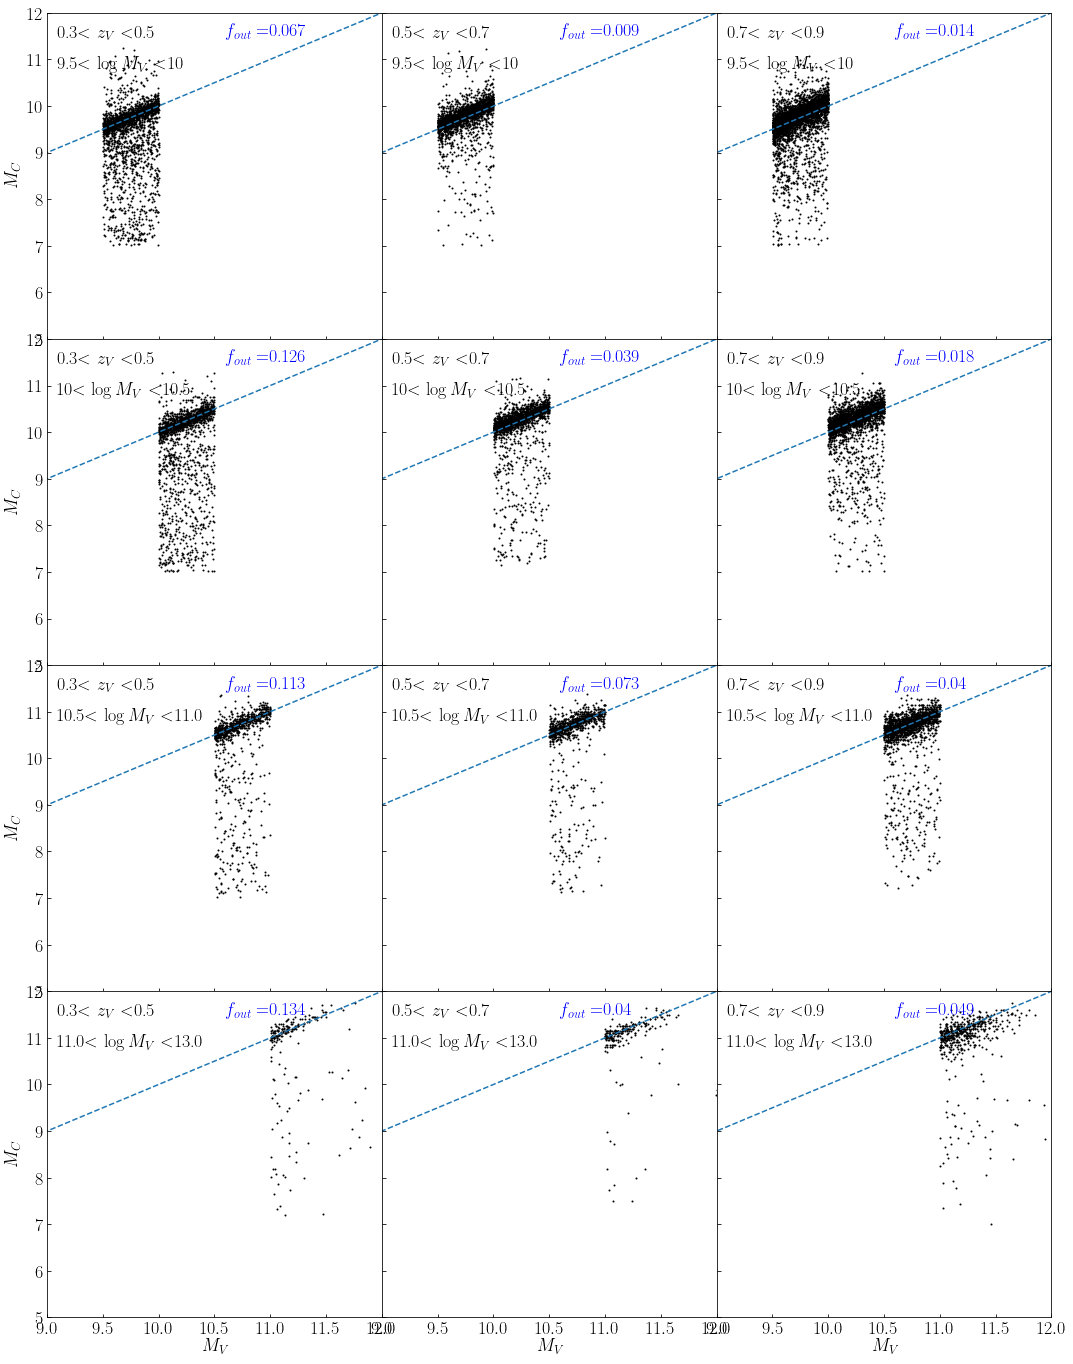

In [23]:
# M vs M plot
fig, axs = plt.subplots(4, 3, figsize=(18,24),sharex=True, sharey=True)

zs = [0.4, 0.6, 0.8]
mass_limits = [9.5,10,10.5,11.0,13.0]

# _1: params from deep+uddd catalog
# _2: params from uddd only (Ugrizy) catalog
cat_gal = cat_v_uddd_and_deep_gal.copy()

for i in range(12):
    row = i // 3
    col = i % 3
    
    z = zs[col]
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']>mass_limits[row]]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']<mass_limits[row+1]]
    
    # 
    axs[row][col].scatter(cat_lv_gal_z['MASS_MED_2'],cat_lv_gal_z['MASS_MED_1'],s=1,color='k')
    axs[row][col].set_xlim([9,12])
    axs[row][col].set_ylim([5,12])
    axs[row][col].plot([5,13],[5,13],'--')
    
    axs[row][col].annotate(str(round(z-0.1,1))+"$<z_V<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
    axs[row][col].annotate(str(mass_limits[row])+"$<\log M_V<$"+str(mass_limits[row+1]),xy=([0.03,0.82]),xycoords='axes fraction',fontsize=18)
    
    axs[3][col].set_xlabel(r'$M_V$',fontsize=18)
    axs[row][0].set_ylabel(r'$M_C$',fontsize=18)
    
     # outlier rate
    outlier_cut = abs(cat_lv_gal_z['MASS_MED_2']-cat_lv_gal_z['MASS_MED_1'])>0.2*cat_lv_gal_z['MASS_MED_2']
    cat_lv_gal_z_outlier = cat_lv_gal_z[outlier_cut]
    outlier_rate = len(cat_lv_gal_z_outlier)/len(cat_lv_gal_z)
    axs[row][col].annotate(r'$f_{out}=$'+str(round(outlier_rate,3)),xy=([0.53,0.92]),xycoords='axes fraction',fontsize=18,color='b')
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)


In [32]:
def gv_boundary_ur(rz):
    ur_1 = 3.06
    ur_2 = 4.5*(rz-0.15) + 1.56
    return np.maximum(ur_1, ur_2)

gv_boundary_rz = 0.75

def urz_class_q(ur,rz):
    return np.array(ur-gv_boundary_ur(rz)>0) * np.array(rz<gv_boundary_rz)


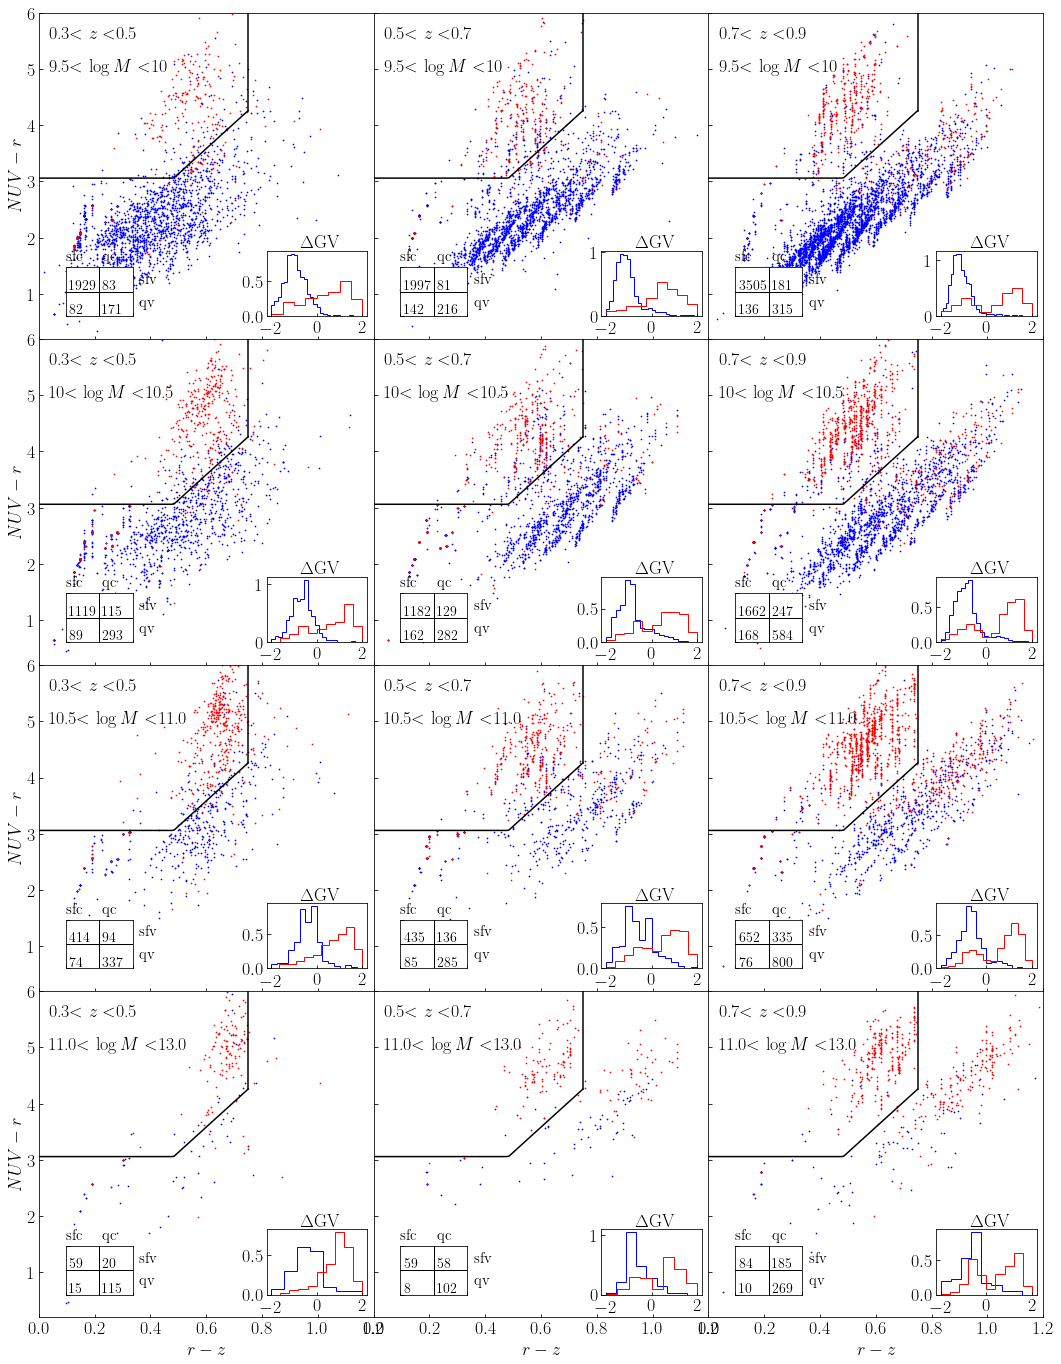

In [33]:
fig, axs = plt.subplots(4, 3, figsize=(18,24),sharex=True, sharey=True)

zs = [0.4, 0.6, 0.8]
mass_limits = [9.5,10,10.5,11.0,13.0]

#  cat_lv_gal) _1: from COSMOS2015
#              _2: from clauds/hsc COSMOS_uddd
cat_gal = cat_v_uddd_and_deep_gal.copy()
for i in range(12):
    row = i // 3
    col = i % 3
    
    z = zs[col]    
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']>mass_limits[row]]  
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED_2']<mass_limits[row+1]]
    
    axs[3][col].set_xlabel(r'$r-z$',fontsize=18)
    axs[row][0].set_ylabel(r'$NUV-r$',fontsize=18)
    axs[row][col].set_xlim([0.0,1.2])
    axs[row][col].set_ylim([0.2,6.])
    
    # draw the selection boundary
    rz_draw = np.linspace(0,0.75,100)
    ur_draw_mid = gv_boundary_ur(rz_draw)

    axs[row][col].plot(rz_draw, ur_draw_mid, color='k')
    axs[row][col].plot([0.75, 0.75],[gv_boundary_ur(0.75), 6.],color='k')
    
    # coordinate limits
    axs[row][col].set_xlim([0.0,1.2])
#     axs[row][col].set_ylim([0.2,3.0])
    
    # Delta_GV (inset plot)
    ax_insert = axs[row][col].inset_axes([0.68, 0.07, 0.3, 0.2])
    
    # Laigle+2016 NUVrJ classification
    cat_lv_gal_z_sf = cat_lv_gal_z[cat_lv_gal_z['CLASS']==1]  #sf
    cat_lv_gal_z_q = cat_lv_gal_z[cat_lv_gal_z['CLASS']==0]  #q
    
    # NUVrK but with color-coding from Laigle+2016 NUVrK classification
    axs[row][col].scatter(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_z'], 
                          cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'],
                         s=0.5,c='b')
    axs[row][col].scatter(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_z'], 
                          cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'],
                         s=0.5,c='r')
    
    # Delta_GV but seprated by Laigle+2016 NUVrK classification (c stands for COSMOS)
    rz_sfc = np.array(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_z'])
    rz_qc = np.array(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_z'])
    
    ur_sfc = np.array(cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'])
    ur_qc = np.array(cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'])
    
    delta_gv_sf = cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r']-gv_boundary_ur(rz_sfc)
    delta_gv_q = cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r']-gv_boundary_ur(rz_qc)
    
    ax_insert.hist(delta_gv_sf,range=(-2,2),bins='scott',histtype='step',color='b',density=True)
    ax_insert.hist(delta_gv_q,range=(-2,2),bins='scott',histtype='step',color='r',density=True)
    
    axs[row][col].annotate(str(round(z-0.1,1))+"$<z<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
    axs[row][col].annotate(str(mass_limits[row])+"$<\log M<$"+str(mass_limits[row+1]),xy=([0.03,0.82]),xycoords='axes fraction',fontsize=18)
    axs[row][col].annotate('$\Delta$GV',xy=([0.78,0.28]),xycoords='axes fraction',fontsize=18)
    
    # contingency table (inset plot 2)
    # clauds_hsc_class _ cosmos_class
    sf_sf = len(cat_lv_gal_z_sf[~urz_class_q(ur_sfc,rz_sfc)])
    q_q = len(cat_lv_gal_z_q[urz_class_q(ur_qc,rz_qc)])
    sf_q = len(cat_lv_gal_z_q[~urz_class_q(ur_qc,rz_qc)])
    q_sf = len(cat_lv_gal_z_sf[urz_class_q(ur_sfc,rz_sfc)])
    
    ax_insert2 = axs[row][col].inset_axes([0.08, 0.07, 0.2, 0.15])
    ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
    ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
    
    axs[row][col].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('sfv',xy=([0.3,0.17]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('qv',xy=([0.3,0.1]),xycoords='axes fraction',fontsize=15)
    
    ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
    ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
    ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
    ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
    
    ax_insert2.set_xlim([-1,1])
    ax_insert2.set_ylim([-1,1])
    ax_insert2.set_yticklabels([])
    ax_insert2.set_xticklabels([])
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

plt.savefig('/Users/lejay/Desktop/NUVrz.pdf')
plt.show()


### mass/z distribution

In [7]:
# redshift cut
z_low=0.3
z_high=0.5

cat_zcut_a = cat_a_gal[abs(cat_a_gal['zKDEPeak']-(z_high+z_low)/2)<(z_high-z_low)/2]
cat_zcut_t = cat_t_gal[abs(cat_t_gal['Z_BEST_BC03']-(z_high+z_low)/2)<(z_high-z_low)/2]
cat_zcut_v = cat_v_gal[abs(cat_v_gal['Z_BEST']-(z_high+z_low)/2)<(z_high-z_low)/2]

print(cat_name)
print('after z cut', len(cat_zcut_a),len(cat_zcut_t),len(cat_zcut_v))

after z cut 292068 127637 323845


In [9]:
# mass cuts
m_low=11.15
m_high=13.0

cat_central_a = cat_zcut_a[abs(cat_zcut_a['MASS_MED']-(m_high+m_low)/2)<(m_high-m_low)/2]
cat_central_t = cat_zcut_t[abs(cat_zcut_t['MASS_MED']-(m_high+m_low)/2)<(m_high-m_low)/2]
cat_central_v = cat_zcut_v[abs(cat_zcut_v['MASS_MED']-(m_high+m_low)/2)<(m_high-m_low)/2]

print(cat_name)
print('massive gals',len(cat_central_a),len(cat_central_t),len(cat_central_v))

COSMOS_deep
massive gals 353 970 641


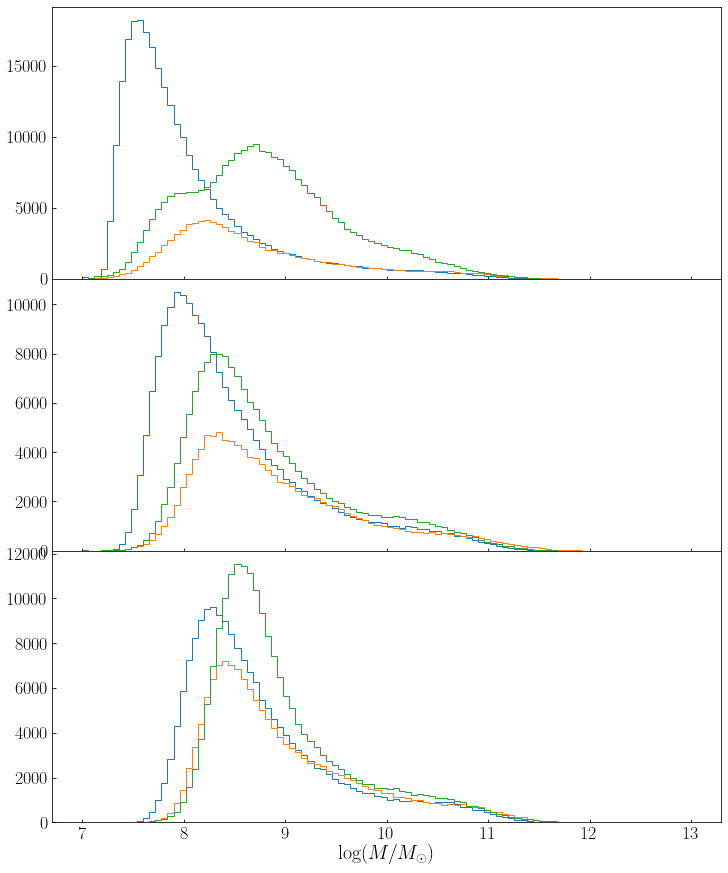

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(12,15),sharex=True)

for i,z in enumerate([0.4,0.6,0.8]):
    cat_a_gal_z = cat_a_gal[abs(cat_a_gal['zKDEPeak']-z)<0.1]
    cat_t_gal_z = cat_t_gal[abs(cat_t_gal['Z_BEST_BC03']-z)<0.1]
    cat_v_gal_z = cat_v_gal[abs(cat_v_gal['Z_BEST']-z)<0.1]
    
    axs[i].hist(cat_a_gal_z['MASS_MED'],bins=100, range=[7,13],histtype='step')
    axs[i].hist(cat_t_gal_z['MASS_MED'],bins=100, range=[7,13],histtype='step')
    axs[i].hist(cat_v_gal_z['MASS_MED'],bins=100, range=[7,13],histtype='step')
    
fig.subplots_adjust(hspace=0)
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=20)
plt.show()

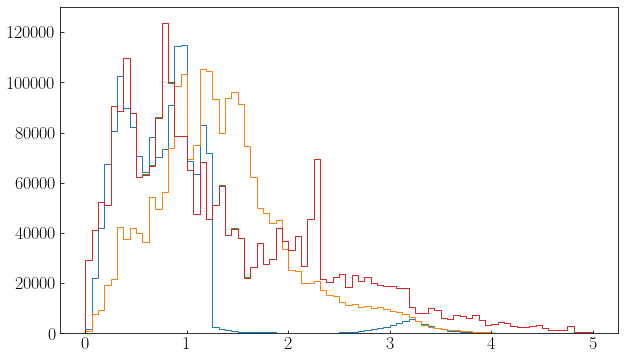

In [15]:
fig = plt.figure(figsize=(10,6))

plt.hist(cat_a_gal['zKDEPeak'],bins=80, range=[0,5],histtype='step')
plt.hist(cat_t_gal['Z_BEST_BC03'],bins=80, range=[0,5],histtype='step')
plt.hist(cat_v_gal['Z_BEST'],bins=80, range=[0,5],histtype='step')
plt.hist(cat_v4_gal['Z_BEST'],bins=80, range=[0,5],histtype='step')
plt.show()

### compare with bagpipes parameters

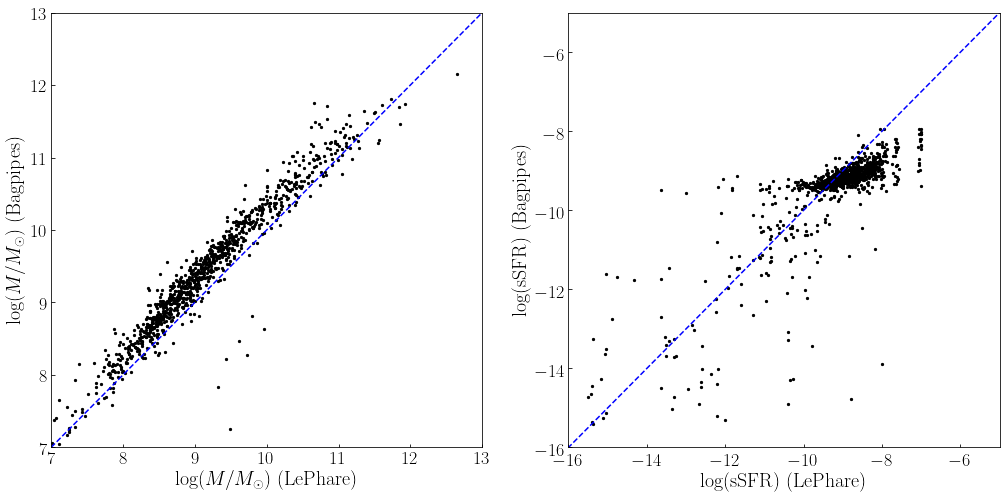

In [23]:
cat_v2020_pipes_added = Table.read('clauds_cat_v2020/COSMOS_deep_pipes_added_rand1000.fits')

m = cat_v2020_pipes_added['MASS_MED']
m_pipes = cat_v2020_pipes_added['stellar_mass_50']

ssfr = cat_v2020_pipes_added['SSFR_MED']
ssfr_pipes = cat_v2020_pipes_added['ssfr_50']


fig, axs = plt.subplots(1, 2, figsize=(17,8))

# mass
axs[0].scatter(m,m_pipes,c='k',s=5)

axs[0].set_xlabel(r'$\log(M/M_\odot)$ (LePhare)', fontsize=20)
axs[0].set_ylabel(r'$\log(M/M_\odot)$ (Bagpipes)', fontsize=20)
axs[0].set_xlim([7,13])
axs[0].set_ylim([7,13])
axs[0].plot([7,13],[7,13],color='b',linestyle='--')

#ssfr
axs[1].scatter(ssfr,ssfr_pipes,c='k',s=5)
axs[1].set_xlabel(r'$\log$(sSFR) (LePhare)', fontsize=20)
axs[1].set_ylabel(r'$\log$(sSFR) (Bagpipes)', fontsize=20)
axs[1].set_xlim([-16,-5])
axs[1].set_ylim([-16,-5])
axs[1].plot([-20,0],[-20,0],color='b',linestyle='--')

plt.show()

In [32]:
cat = Table.read('CUT_deep_catalogs/DEEP_deep_v1v2.fits')
cat_v2detected = cat[cat['i_1']>0]

In [43]:
#1-v2 , 2-v1
bins = np.linspace(7,13,100)

mass_hist_all, bin_edges = np.histogram(np.array(cat['MASS_MED_1']),range=(7,13),bins=bins)
mass_hist_v2detected, bin_edges = np.histogram(np.array(cat_v2detected['MASS_MED_1']),range=(7,13),bins=bins)

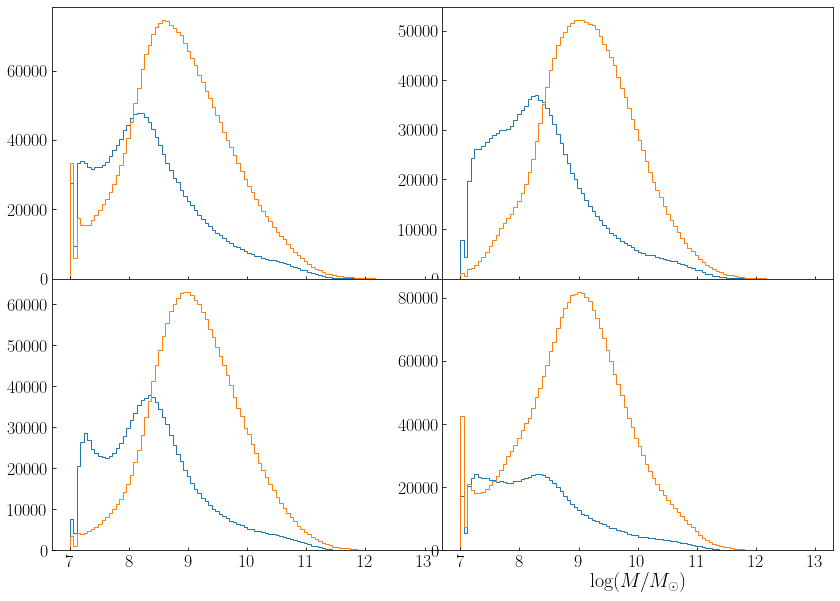

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14,10),sharex=True)

for i,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep','XMM-LSS_deep']):
    # 1) Anneya's catalog
    cat_a = Table.read('CUT_deep_catalogs/s16a_'+cat_name+'_masterCat.fits')
    cat_a_unmask = cat_a
    cat_a_inside = cat_a_unmask[cat_a_unmask['inside']==True]
    cat_a_gal = cat_a_inside[cat_a_inside['preds_median']<0.89]

    # # 3) Vincent's catalog
    cat_v = Table.read('clauds_cat_v2020/'+cat_name+'_v2_v200930.fits')
    cat_v_unmask = cat_v[cat_v['MASK']==0]
    if cat_name =='XMM-LSS_deep':
        cat_v_inside = cat_v_unmask[cat_v_unmask['FLAG_FIELD_BINARY'][:,2]==True]
    else:
        cat_v_inside = cat_v_unmask[cat_v_unmask['FLAG_FIELD_BINARY'][:,1]==True]
        
    cat_v_gal = cat_v_inside[cat_v_inside['OBJ_TYPE'] == 0]
    
    row = i//2
    col = i%2
    axs[row][col].hist(cat_a_gal['MASS_MED'],bins=100, range=[7,13],histtype='step')
    axs[row][col].hist(cat_v_gal['MASS_MED'],bins=100, range=[7,13],histtype='step')
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=20)
plt.show()

### one patch in central COSMOS

9813 5,5

In [202]:
cat_name = 'DEEP_deep'
cat_a = Table.read('CUT_deep_catalogs/s16a_'+cat_name+'_masterCat.fits')
cat_a_unmask = cat_a
cat_a_inside = cat_a_unmask[cat_a_unmask['inside']==True]
cat_a_gal = cat_a_inside[cat_a_inside['preds_median']<0.89]

cat_t = Table.read('CUT_deep_catalogs/UV_CLAUDS_HSC_S16A_'+cat_name+'.fits')
cat_t_unmask = cat_t
cat_t_gal = cat_t_unmask[cat_t_unmask['CLASS']==0]

cat_v = Table.read('clauds_cat_v2020/'+cat_name+'_v2_v200930.fits')
cat_v_unmask = cat_v[cat_v['MASK']==0]
cat_v_inside = cat_v_unmask[cat_v_unmask['FLAG_FIELD_BINARY'][:,1]==True]
cat_v_gal = cat_v_inside[cat_v_inside['OBJ_TYPE'] == 0]

In [204]:
# catalog of objects in one patch 
tract = 9463
patch = '3,2'

cat_a_tract = cat_a_gal[cat_a_gal['TRACT']==tract]
cat_a_patch = cat_a_tract[cat_a_tract['PATCH']==patch]

cat_t_tract = cat_t_gal[cat_t_gal['TRACT']==tract]
cat_t_patch = cat_t_tract[cat_t_tract['PATCH']==patch]

cat_v_tract = cat_v_gal[cat_v_gal['TRACT']==tract]
cat_v_patch = cat_v_tract[cat_v_tract['PATCH']==patch]

ra_min = min(cat_a_patch['RA'])
ra_max = max(cat_a_patch['RA'])
dec_min = min(cat_a_patch['DEC'])
dec_max = max(cat_a_patch['DEC'])
cat_l = Table.read('COSMOS2015_Laigle+_v1.1.fits')
cat_l_gal = cat_l[np.logical_and(cat_l['TYPE']==0, cat_l['FLAG_PETER']==0)]
cat_l_patch_ra = cat_l_gal[np.logical_and(cat_l_gal['ALPHA_J2000']>ra_min, cat_l_gal['ALPHA_J2000']<ra_max)]
cat_l_patch = cat_l_patch_ra[np.logical_and(cat_l_patch_ra['DELTA_J2000']>dec_min, cat_l_patch_ra['DELTA_J2000']<dec_max)]

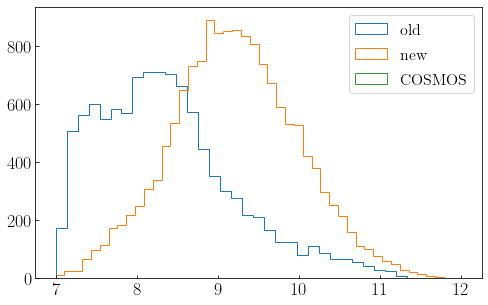

In [206]:
fig = plt.figure(figsize=(8,5))

plt.hist(cat_a_patch['MASS_MED'], bins='scott', range=[7,12],histtype='step',label='old')
plt.hist(cat_v_patch['MASS_MED'], bins='scott', range=[7,12],histtype='step',label='new')
# plt.hist(cat_l_patch['MASS_MED'], bins='scott', range=[7,12],histtype='step',label='COSMOS')
plt.legend(fontsize=16)
plt.show()

In [209]:
# cut for z<1
cat_a_patch_lowz = cat_a_patch[cat_a_patch['zKDEPeak']<1]
cat_t_patch_lowz = cat_t_patch[cat_t_patch['Z_BEST_BC03']<1]
cat_v_patch_lowz = cat_v_patch[cat_v_patch['Z_BEST']<1]
cat_l_patch_lowz = cat_l_patch[cat_l_patch['ZPDF']<1]

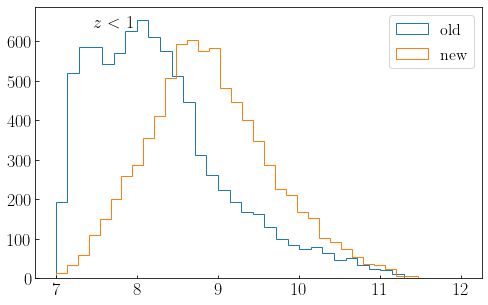

In [210]:
fig = plt.figure(figsize=(8,5))
plt.annotate("$z<1$",xy=([0.13,0.92]),xycoords='axes fraction',fontsize=18)
plt.hist(cat_a_patch_lowz['MASS_MED'], bins='scott', range=[7,12],histtype='step',label='old')
plt.hist(cat_v_patch_lowz['MASS_MED'], bins='scott', range=[7,12],histtype='step',label='new')
# plt.hist(cat_l_patch_lowz['MASS_MED'], bins='scott', range=[7,12],histtype='step',label='COSMOS')
plt.legend(fontsize=16)
plt.show()

### catalog comparison
anneya's, vincent's v2 and v4 (v3 in COSMOS_uddd)

Text(0, 0.5, '$\\log(M/M_\\odot)$')

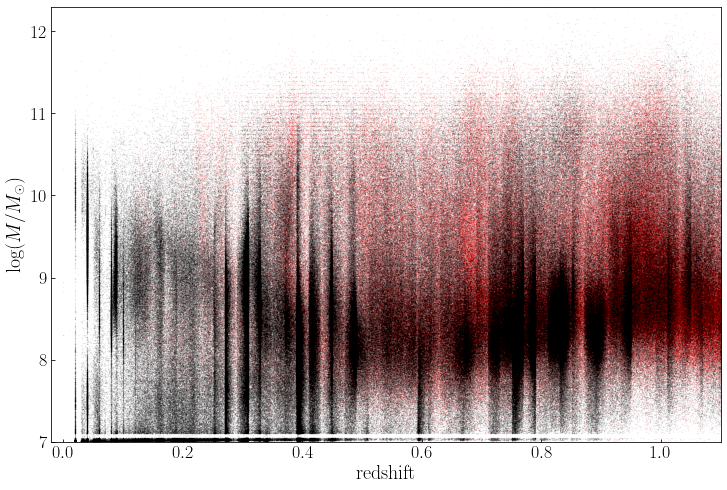

In [34]:
fig = plt.figure(figsize=(12,8))

plt.scatter(cat_t_gal['zKDEPeak'], cat_t_gal['MASS_MED'],s=0.1,alpha=0.1,c='r')
plt.scatter(cat_v4_gal['Z_BEST'], cat_v4_gal['MASS_MED'],s=0.1,alpha=0.1,c='k')
plt.xlim([-0.02,1.1])
plt.ylim([7,12.3])

plt.xlabel('redshift',fontsize=20)
plt.ylabel(r'$\log(M/M_\odot)$',fontsize=20)